**Auteurs** : Charlène PETIT
Alexandre LY
Badr LABRIRHLI


#Import

In [0]:
%%bash
apt-get install libgeos-3* libgeos-dev
pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-3.6.2 is already the newest version (3.6.2-1build2).
libgeos-3.6.2 set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (977 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing t

In [0]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


In [0]:
params = {'legend.fontsize': 'x-large',
          'figure.titlesize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)



In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='cea',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)


# Global SSH Time series

In [0]:
%%bigquery --project alert-ground-261008 output2
SELECT time, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-35 AND lat<35 AND lon>0 AND lon<360
GROUP BY time
ORDER BY time

In [0]:
w=1/365.25
w2=6*w # 2 months cycle
w6=2*w # 6 months cycle


t=output2.time
# define a linear trend
x1=t
# define a annual seasonal cycle
x2 = np.sin(2*np.pi*t*w)
x3 = np.cos(2*np.pi*t*w)
# define a  2 months seasonal cycle
x4 = np.sin(2*np.pi*t*w2)
x5 = np.cos(2*np.pi*t*w2)
# define a  6 months seasonal cycle
x6 = np.sin(2*np.pi*t*w6)
x7 = np.cos(2*np.pi*t*w6)
### Seasonal cycles

Text(0.5, 1.0, 'SSH time series')

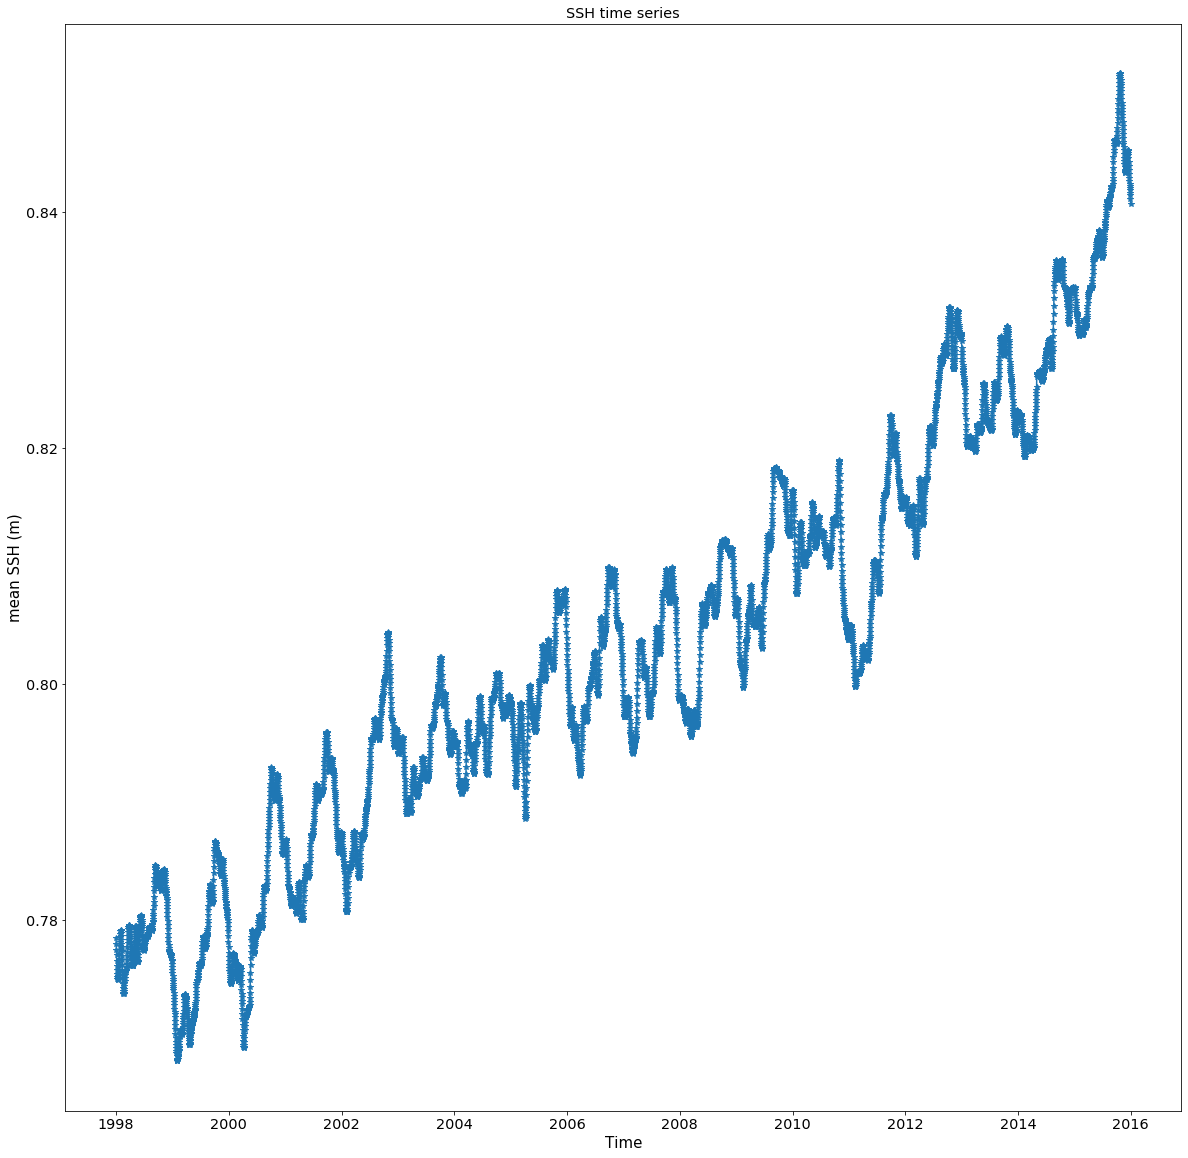

In [0]:
figure()
plot_ts(output2.time,output2.mean_ssh,'-*', 'mean SSH (m)')
plt.title('SSH time series')

# Simple Linear model

In [0]:
# 1: create the matrix X
X = np.vstack((x1,x2,x3,x4,x5,x6,x7)).T
print('The shape of X is {}'.format(X.shape))


# 2: create the model, as before
model = LinearRegression()

# 3: fit the model, as before
model.fit(X,output2.mean_ssh)

The shape of X is (6574, 7)


NameError: ignored

In [0]:
# 4: get predicted values for y, as before
y_hat = model.predict(X)
mean_squared_error(output2.mean_ssh,y_hat)

1.7848556829251178e-05

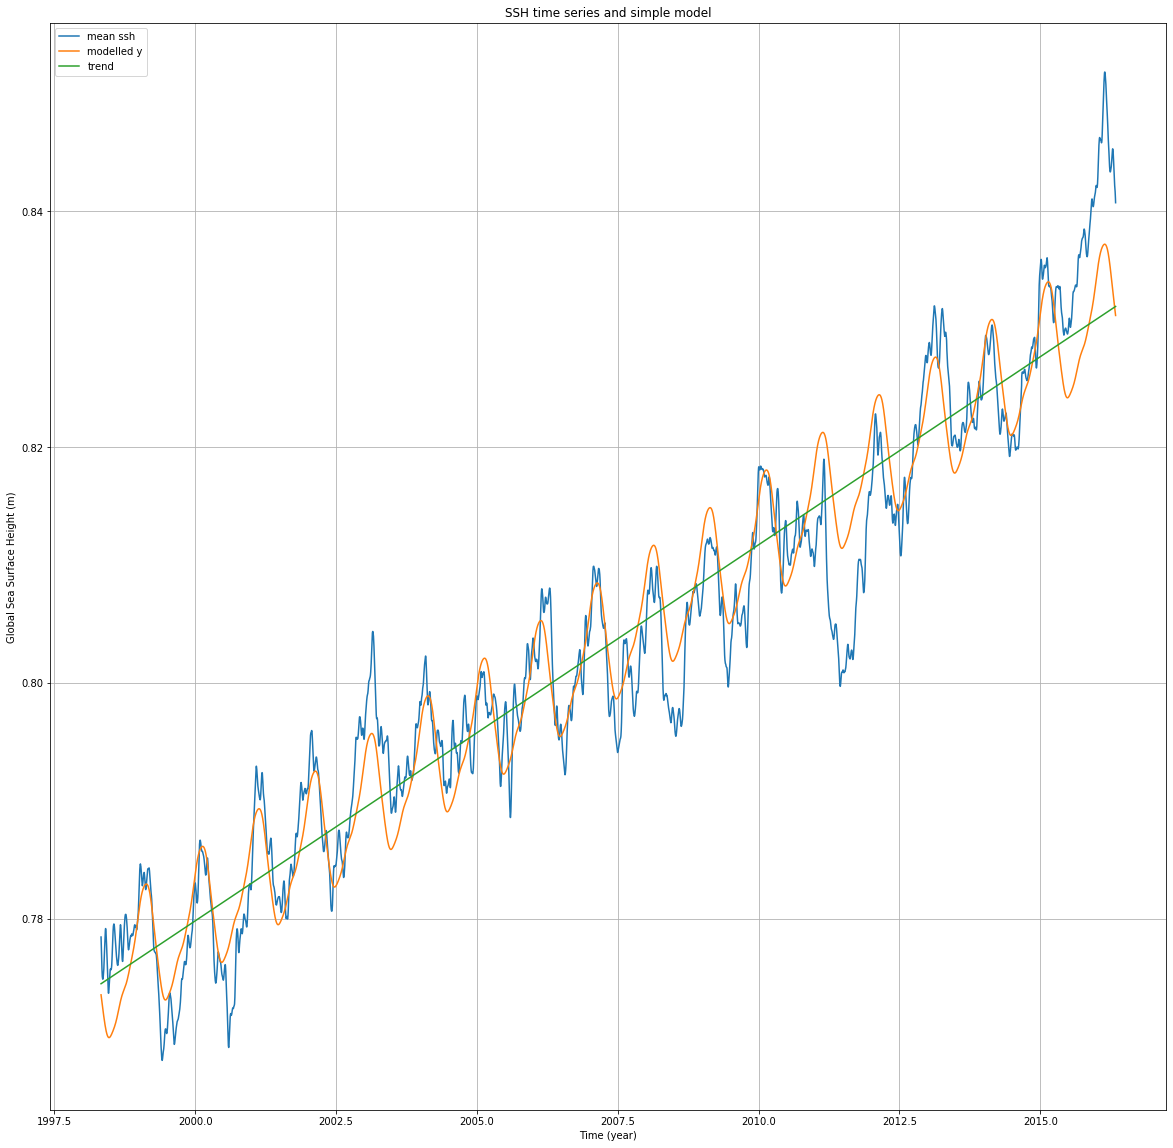

In [0]:
# 5: plot the real and modelled values
plt.figure()
plt.plot(t/365,output2.mean_ssh,label='mean ssh')
plt.plot(t/365,y_hat,label='modelled y')
plt.plot(t/365,model.coef_[0]*t+model.intercept_,label='trend')
plt.legend()
plt.title('SSH time series and simple model')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.grid()

Text(0, 0.5, 'Error (m)')

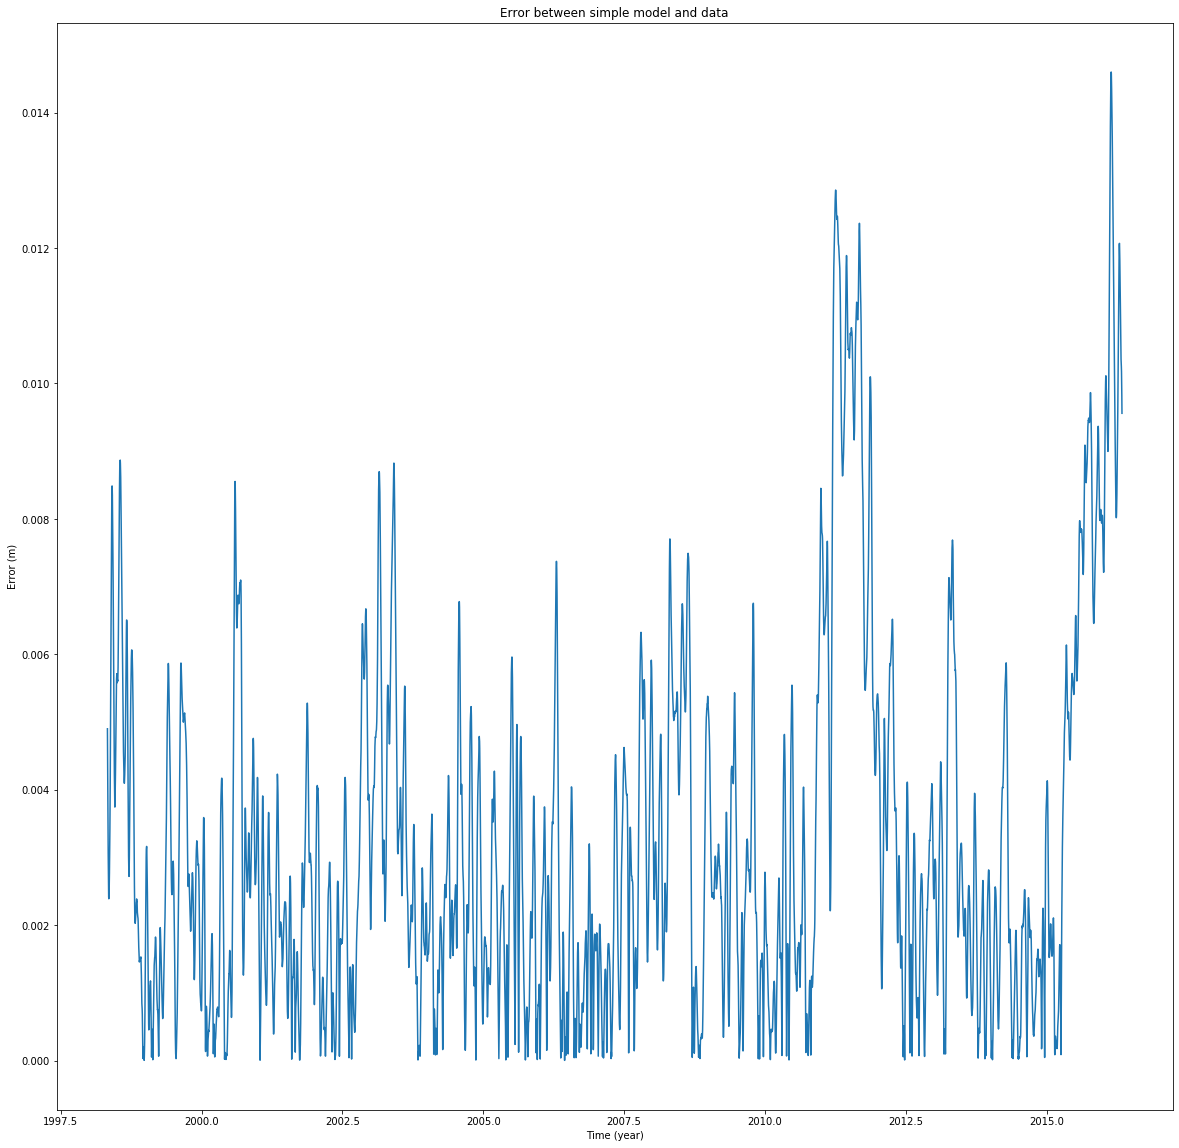

In [0]:
#error simple model
variance_simple=(abs(output2.mean_ssh-y_hat))
figure()
plt.title('Error between simple model and data')
plt.plot(t/365,variance_simple,label='error')
plt.xlabel('Time (year)')
plt.ylabel('Error (m)')

In [0]:
print('Model coefficient for b: {}'.format(model.intercept_))
print('Model coefficients for [a1, a2, a3, a4, a5,a6,a7]: {}'.format(model.coef_))

Model coefficient for b: -5.59750415589615
Model coefficients for [a1, a2, a3, a4, a5,a6,a7]: [ 8.73606256e-06 -4.78564405e-03 -1.42836489e-03 -3.67542957e-05
  8.69976448e-05 -6.52124681e-04 -1.21191877e-03]


# Complex Linear model

In [0]:
x8=t**2
x9=t**3

# 1': create the matrix X
X2 = np.vstack((x1,x2,x3,x4,x5,x6,x7,x8,x9)).T

# 2': create the model, as before
model2 = LinearRegression()

# 3': fit the model, as before
model2.fit(X2,output2.mean_ssh)

# 4: get predicted values for y, as before
y_hat2 = model2.predict(X2)
print('rmse : ',mean_squared_error(output2.mean_ssh,y_hat2))

rmse :  1.655302583023616e-05


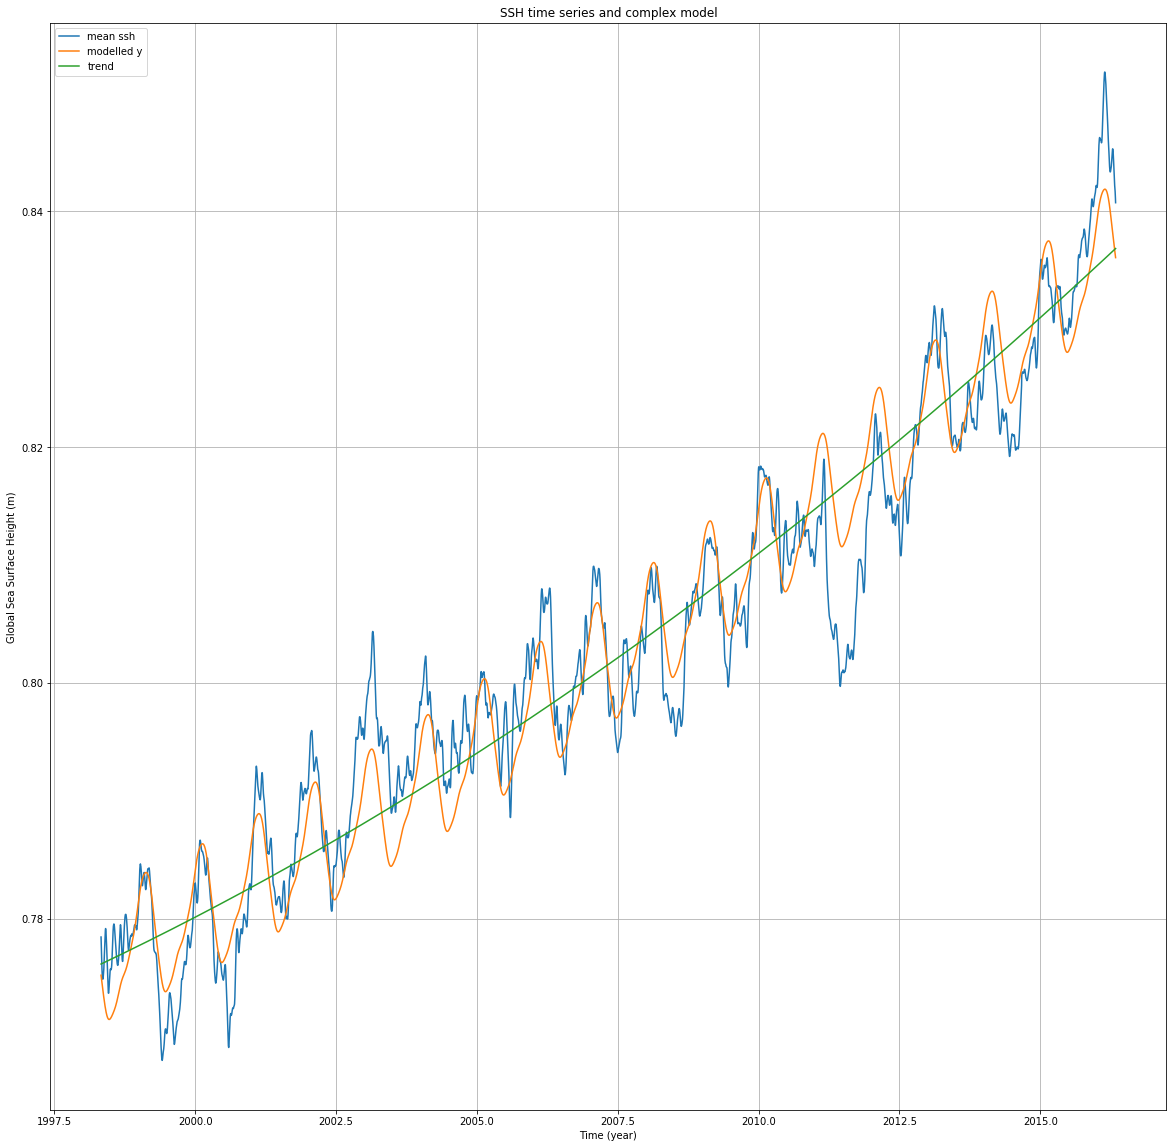

In [0]:
# 5: plot the real and modelled values
plt.figure()
plt.plot(t/365,output2.mean_ssh,label='mean ssh')
plt.plot(t/365,y_hat2,label='modelled y')
plt.plot(t/365,model2.coef_[0]*t+model2.coef_[7]*t**2+model2.coef_[8]*t**3+model2.intercept_,label='trend')
plt.title('SSH time series and complex model')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.legend()
plt.grid()

Text(0, 0.5, 'Error (m)')

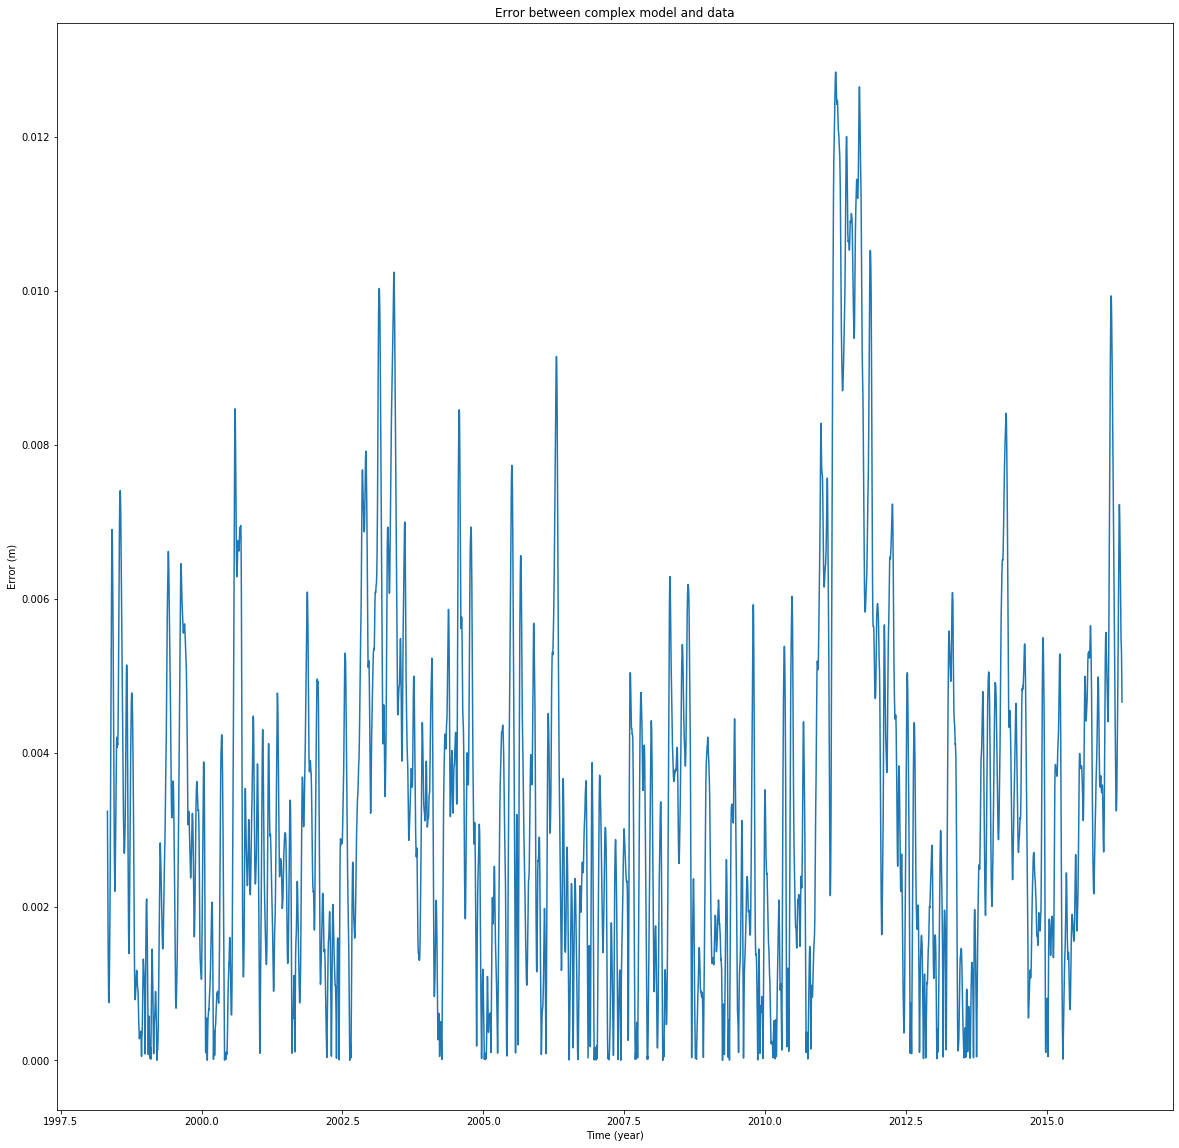

In [0]:
#error complex model
variance_complex=(abs(output2.mean_ssh-y_hat2))
figure()
plt.plot(t/365,variance_complex,label='error')
plt.title('Error between complex model and data')
plt.xlabel('Time (year)')
plt.ylabel('Error (m)')

# 100-year Predictions using simple and complex models

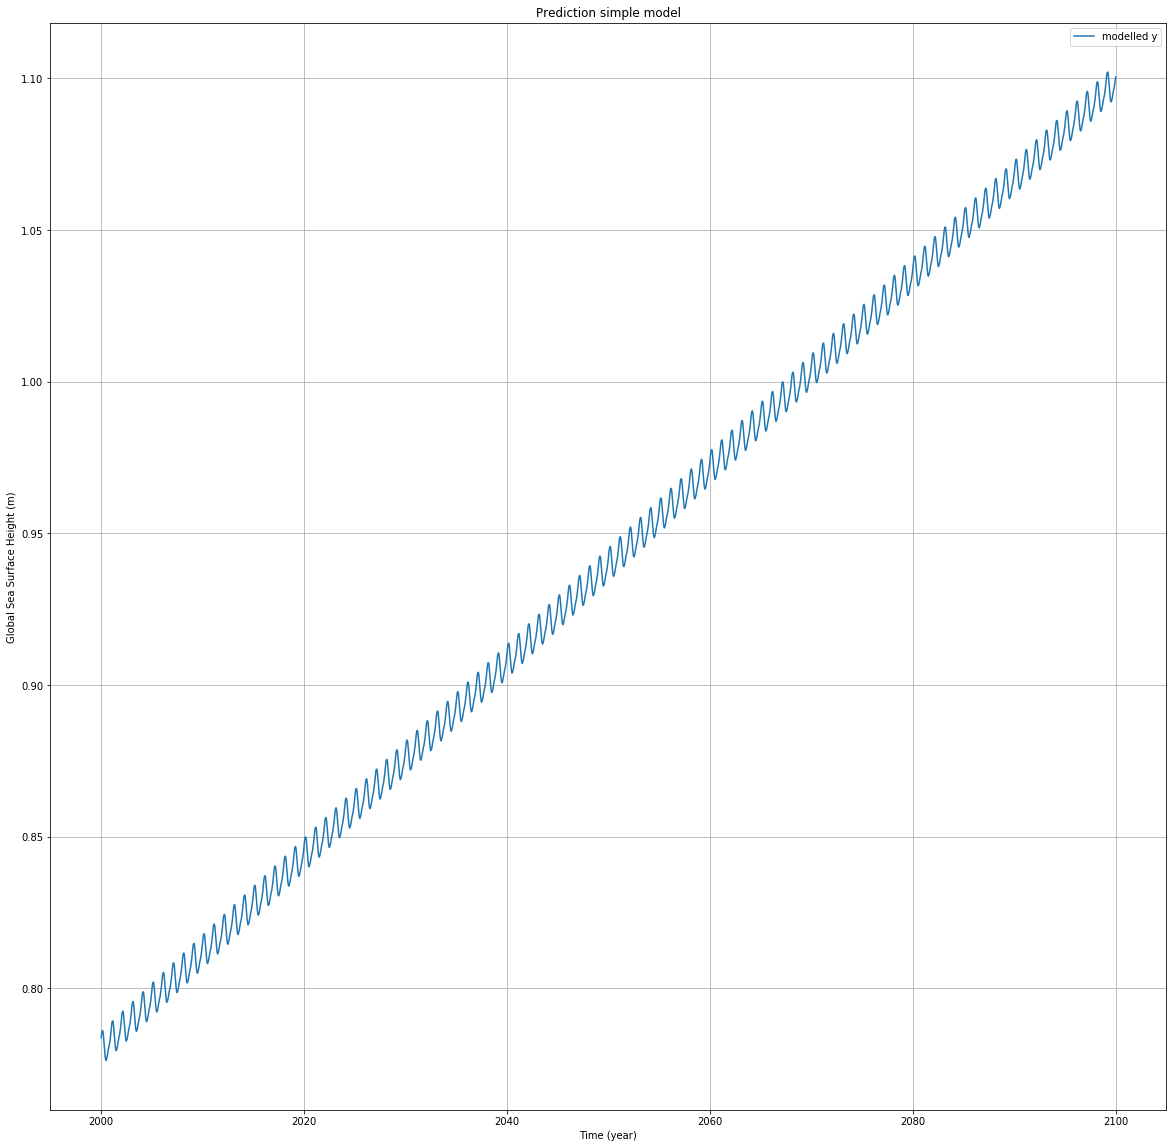

In [0]:
#prediction 2100 simple model
end=730000+36500
t_f= np.linspace(730000,end, 36500)

x1f=t_f
# define a annual seasonal cycle
x2f = np.sin(2*np.pi*t_f*w)
x3f = np.cos(2*np.pi*t_f*w)
# define a 2 months seasonal cycle
x4f = np.sin(2*np.pi*t_f*w2)
x5f = np.cos(2*np.pi*t_f*w2)
# define a 6 months seasonal cycle
x6f = np.sin(2*np.pi*t_f*w6)
x7f = np.cos(2*np.pi*t_f*w6)
Xf = np.vstack((x1f,x2f,x3f,x4f,x5f,x6f,x7f)).T

y_predict = model.predict(Xf)

# plot the modelled values
plt.figure()
plt.plot(t_f/365,y_predict,label='modelled y')
plt.legend()
plt.title('Prediction simple model')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.grid()

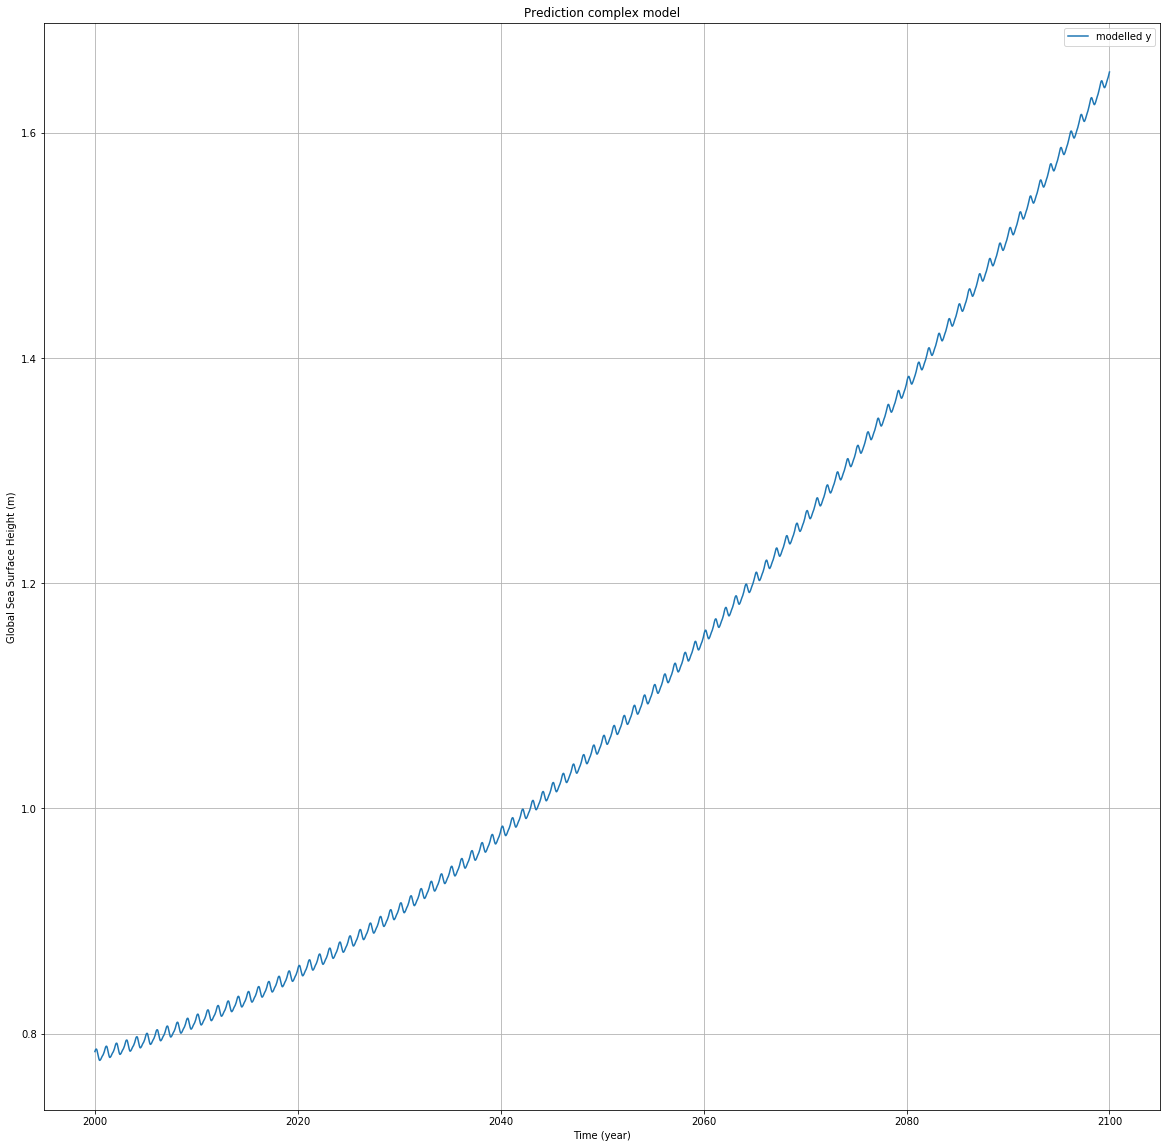

In [0]:
#prediction 2100 more complex model
end=730000+36500
t_f= np.linspace(730000,end, 36500)

x1f=t_f
# define a annual seasonal cycle
x2f = np.sin(2*np.pi*t_f*w)
x3f = np.cos(2*np.pi*t_f*w)
# define a 2 months seasonal cycle
x4f = np.sin(2*np.pi*t_f*w2)
x5f = np.cos(2*np.pi*t_f*w2)
# define a 6 months seasonal cycle
x6f = np.sin(2*np.pi*t_f*w6)
x7f = np.cos(2*np.pi*t_f*w6)
x8f=t_f**2
x9f=t_f**3

X2f = np.vstack((x1f,x2f,x3f,x4f,x5f,x6f,x7f,x8f,x9f)).T


y_predict2 = model2.predict(X2f)

# plot the modelled values
plt.figure()
plt.plot(t_f/365,y_predict2,label='modelled y')
plt.title('Prediction complex model')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.legend()
plt.grid()

## Model 100-year comparison

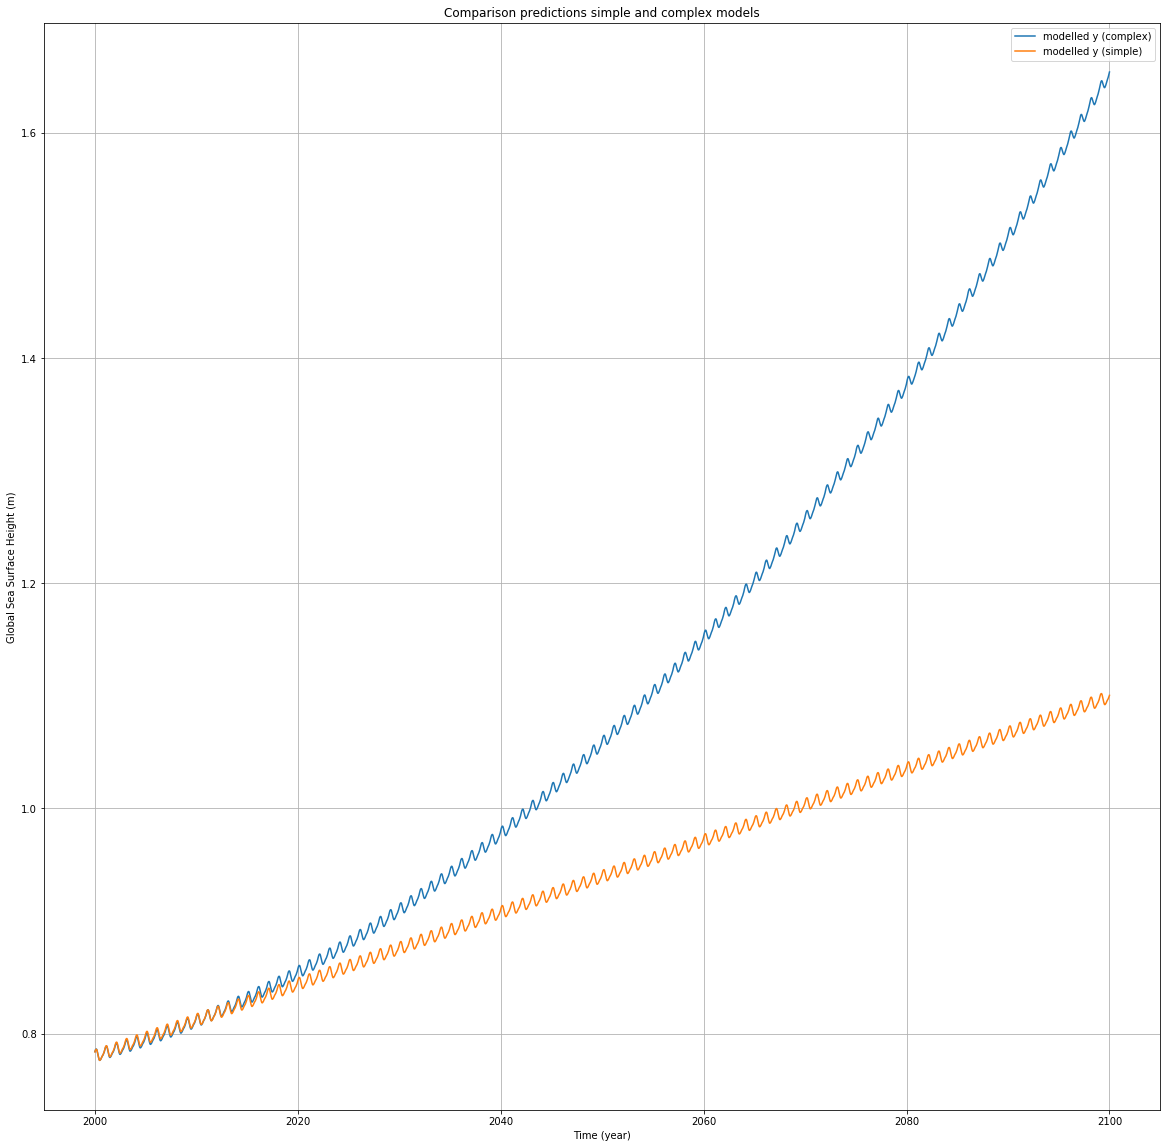

In [0]:
plt.figure()
plt.plot(t_f/365,y_predict2,label='modelled y (complex)')
plt.plot(t_f/365,y_predict,label='modelled y (simple)')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.title('Comparison predictions simple and complex models')
plt.legend()
plt.grid()

# Confidence interval for both models by estimating the future errors

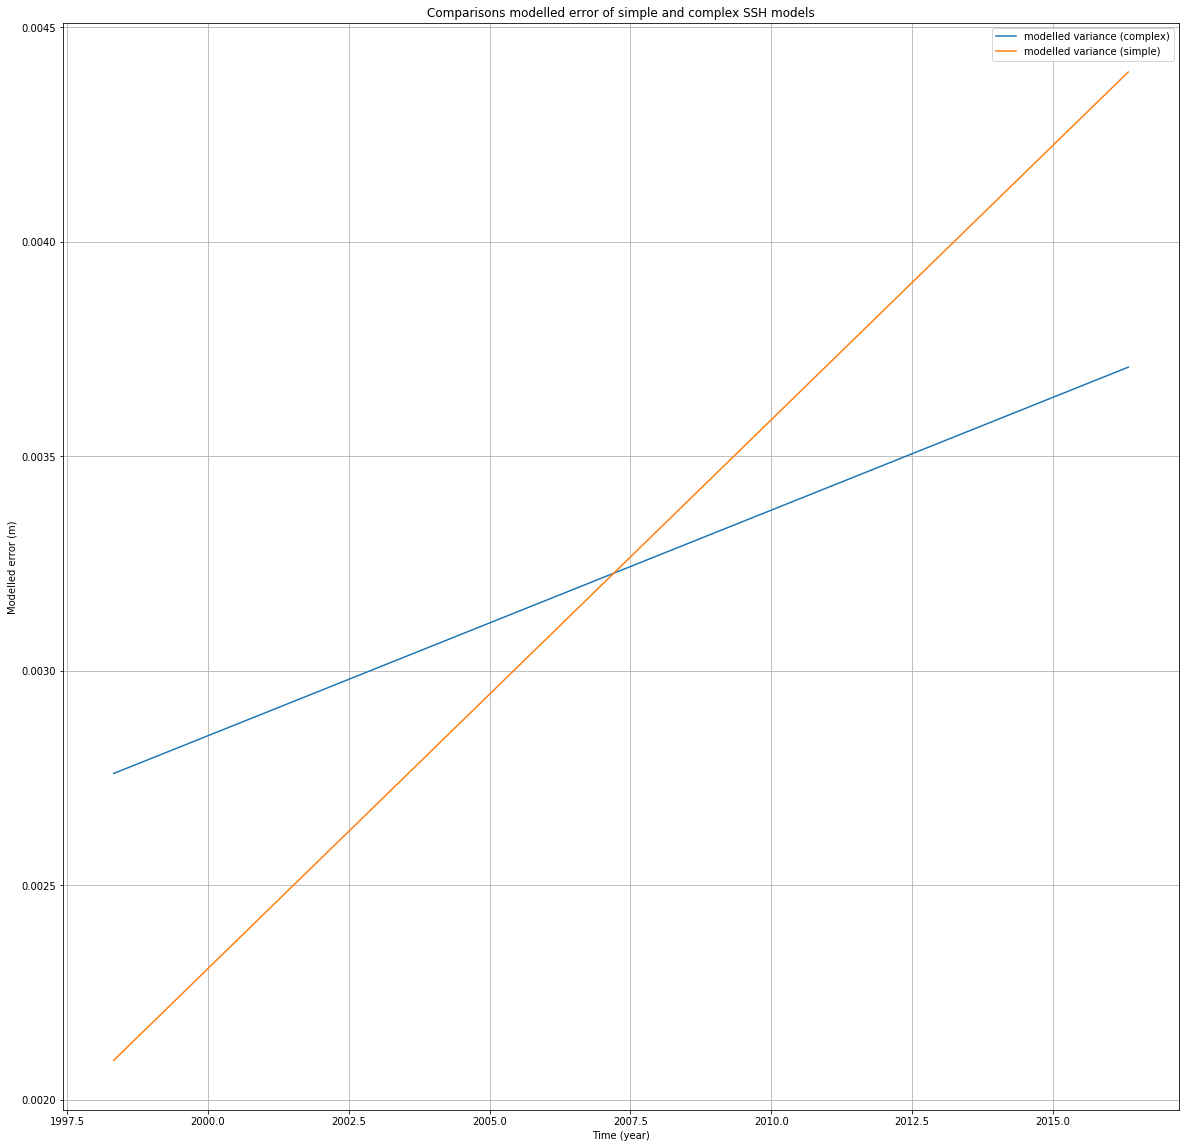

In [0]:
t=output2.time
# define a linear trend
x1=t

model_var_c = LinearRegression()
model_var_s = LinearRegression()

model_var_c.fit(x1[:,None],variance_complex[:,None])
model_var_s.fit(x1[:,None],variance_simple[:,None])

y_var_c = model_var_c.predict(x1[:,None])
y_var_s = model_var_s.predict(x1[:,None])

plt.figure()
plt.plot(t/365,y_var_c,label='modelled variance (complex)')
plt.plot(t/365,y_var_s,label='modelled variance (simple)')
plt.title('Comparisons modelled error of simple and complex SSH models')
plt.xlabel('Time (year)')
plt.ylabel('Modelled error (m)')
plt.legend()
plt.grid()

In [0]:
print('errors : ', mean_squared_error(variance_simple,y_var_s),mean_squared_error(variance_complex,y_var_c))

errors :  6.882542586443599e-06 6.017170429251855e-06


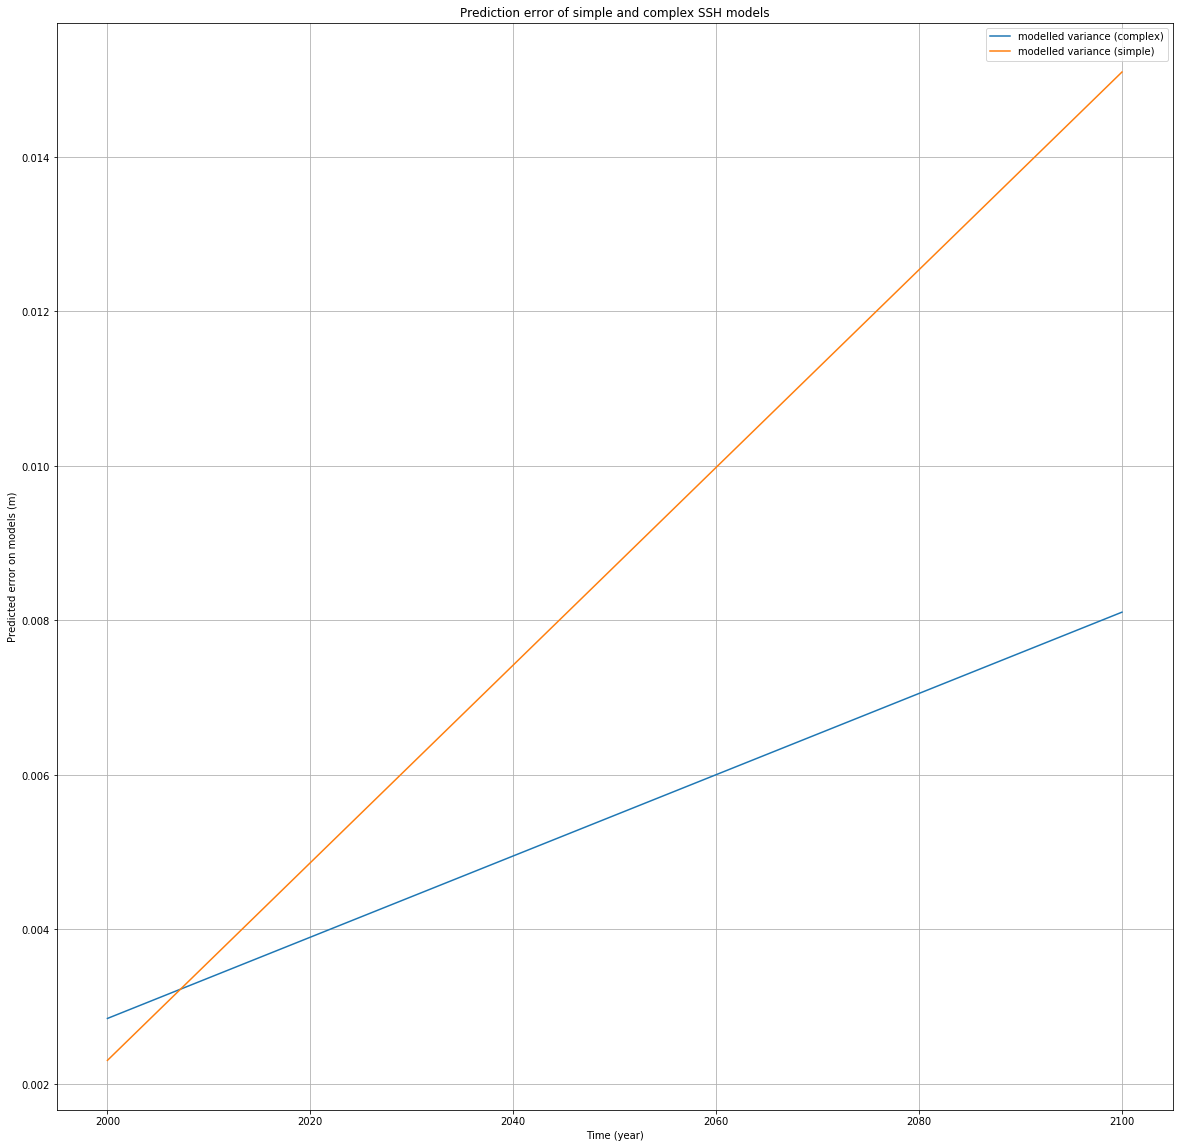

In [0]:
#prediction variance

#prediction 2100 more complex model
end=730000+36500
t_f= np.linspace(730000,end, 36500)

x1f=t_f


y_predict_var_c = model_var_c.predict(x1f[:,None])
y_predict_var_s = model_var_s.predict(x1f[:,None])

plt.figure()
plt.plot(t_f/365,y_predict_var_c,label='modelled variance (complex)')
plt.plot(t_f/365,y_predict_var_s,label='modelled variance (simple)')
plt.title('Prediction error of simple and complex SSH models')
plt.xlabel('Time (year)')
plt.ylabel('Predicted error on models (m)')
plt.legend()
plt.grid()

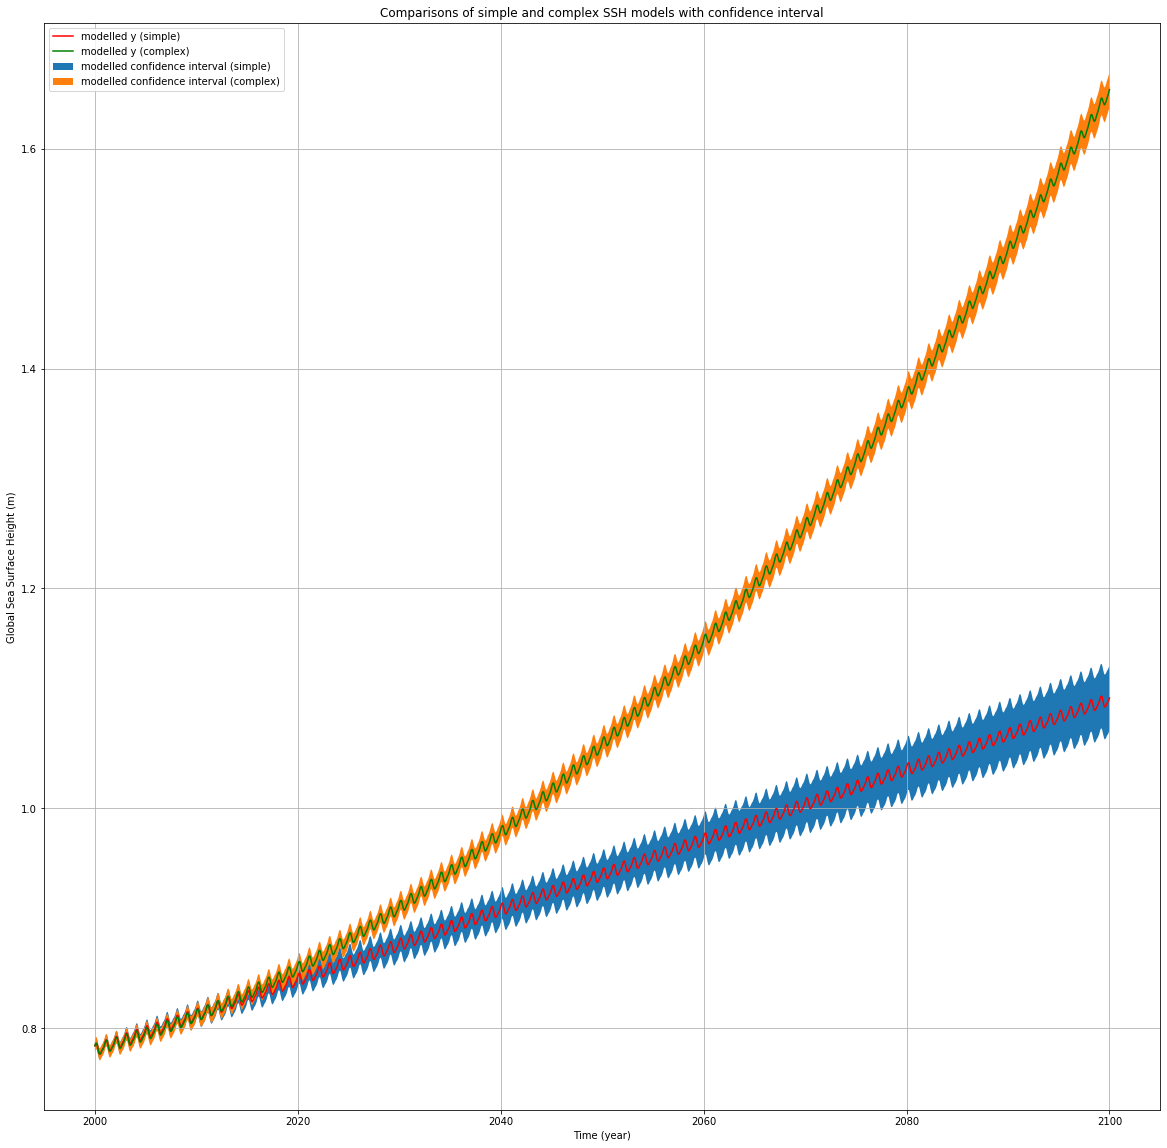

In [0]:
import matplotlib.pyplot as plt
plt.figure()

confidence_min_c=y_predict2-1.96*y_predict_var_c.flatten()
confidence_max_c=y_predict2+1.96*y_predict_var_c.flatten()

confidence_min_s=y_predict-1.96*y_predict_var_s.flatten()
confidence_max_s=y_predict+1.96*y_predict_var_s.flatten()

plt.fill_between(t_f/365,confidence_min_s,confidence_max_s, label='modelled confidence interval (simple)')
plt.plot(t_f/365,y_predict,'r',label='modelled y (simple)')


plt.fill_between(t_f/365,confidence_min_c,confidence_max_c, label='modelled confidence interval (complex)')
plt.plot(t_f/365,y_predict2,'g',label='modelled y (complex)')
plt.title('Comparisons of simple and complex SSH models with confidence interval')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.legend()
plt.grid()

# Test model with error model more complex

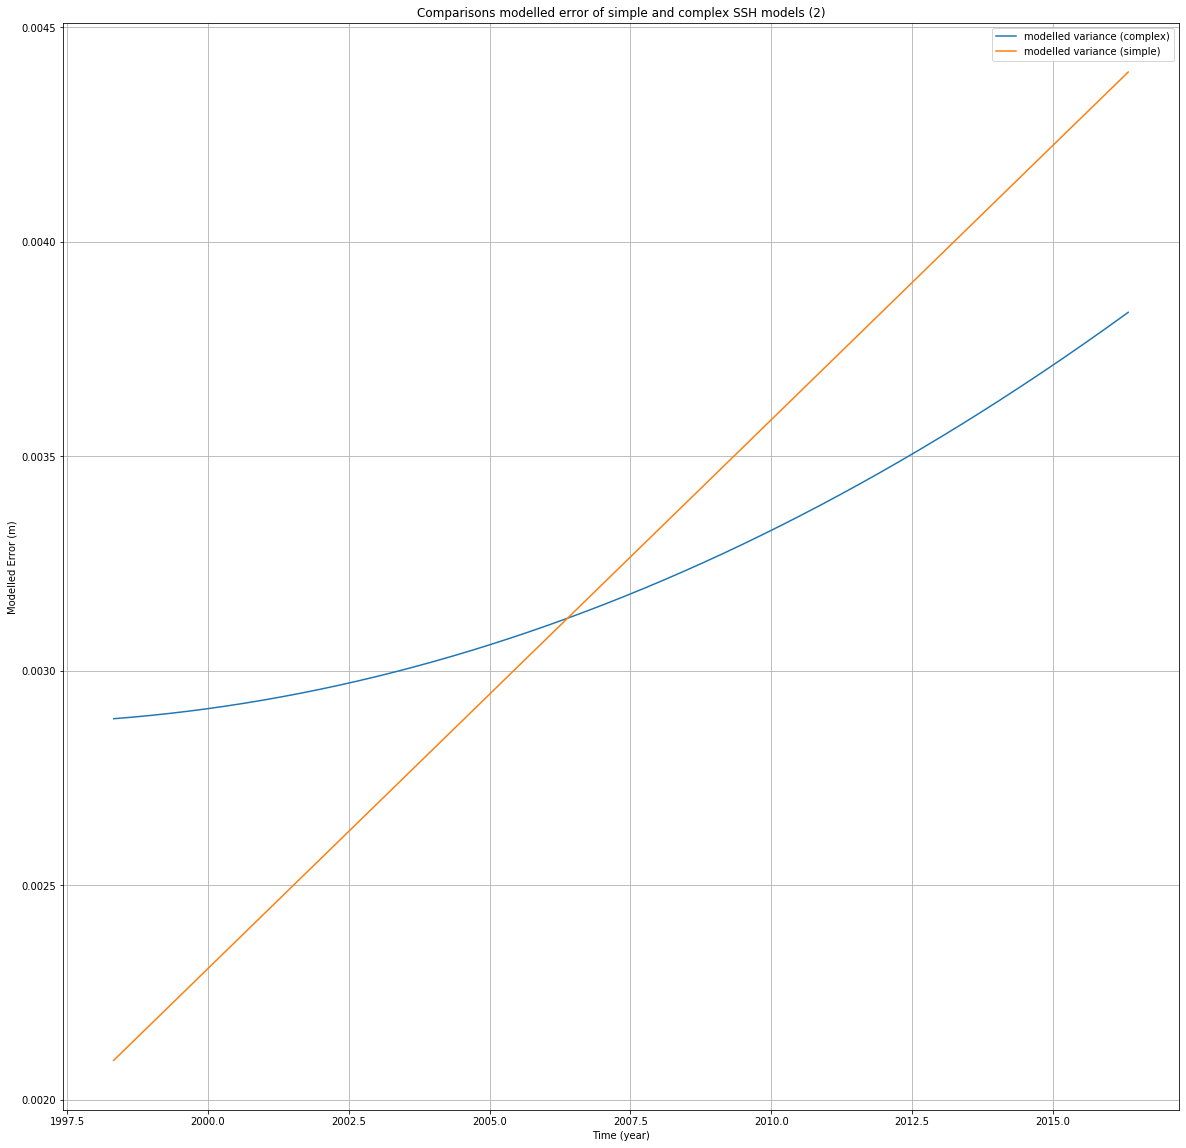

In [0]:
t=output2.time
# define a linear trend
x1=t
x2=t**3


model_var_c = LinearRegression()
model_var_s = LinearRegression()

X3 = np.vstack((x1,x2)).T

model_var_c.fit(X3,variance_complex[:,None])
model_var_s.fit(x1[:,None],variance_simple[:,None])

y_var_c = model_var_c.predict(X3)
y_var_s = model_var_s.predict(x1[:,None])

plt.figure()
plt.plot(t/365,y_var_c,label='modelled variance (complex)')
plt.plot(t/365,y_var_s,label='modelled variance (simple)')
plt.title('Comparisons modelled error of simple and complex SSH models (2)')
plt.xlabel('Time (year)')
plt.ylabel('Modelled Error (m)')
plt.legend()
plt.grid()


In [0]:
print('errors : ', mean_squared_error(variance_simple,y_var_s),mean_squared_error(variance_complex,y_var_c))


errors :  6.882542586443599e-06 6.013902049407546e-06


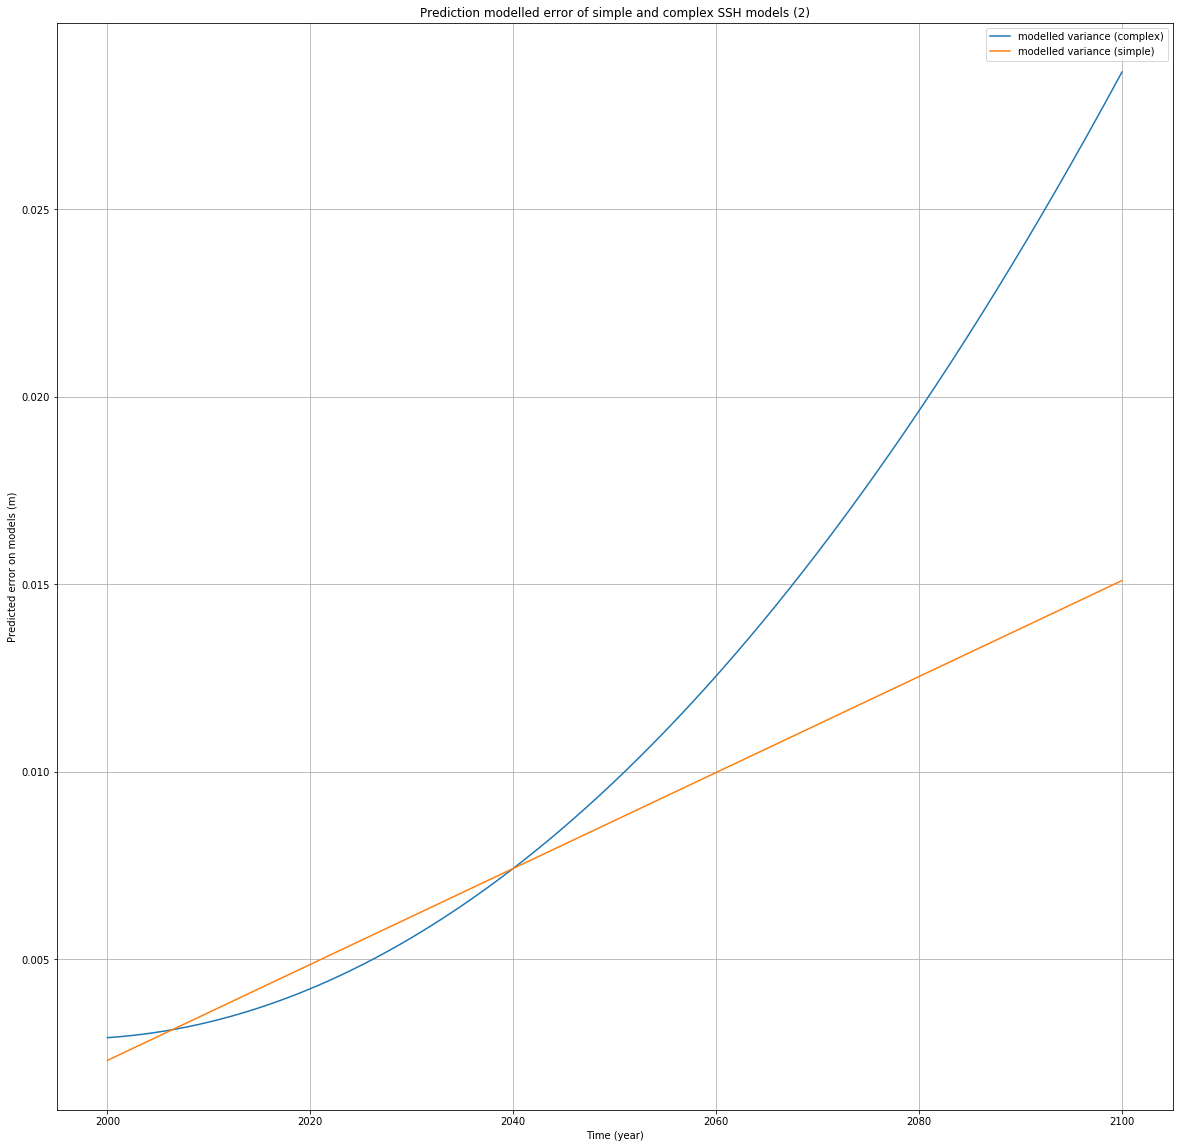

In [0]:
#prediction variance

#prediction 2100 more complex model
end=730000+36500
t_f= np.linspace(730000,end, 36500)

x1f=t_f
x2f=t_f**3

X3f = np.vstack((x1f,x2f)).T


y_predict_var_c = model_var_c.predict(X3f)
y_predict_var_s = model_var_s.predict(x1f[:,None])

plt.figure()
plt.plot(t_f/365,y_predict_var_c,label='modelled variance (complex)')
plt.plot(t_f/365,y_predict_var_s,label='modelled variance (simple)')
plt.title('Prediction modelled error of simple and complex SSH models (2)')
plt.xlabel('Time (year)')
plt.ylabel('Predicted error on models (m)')
plt.legend()
plt.grid()

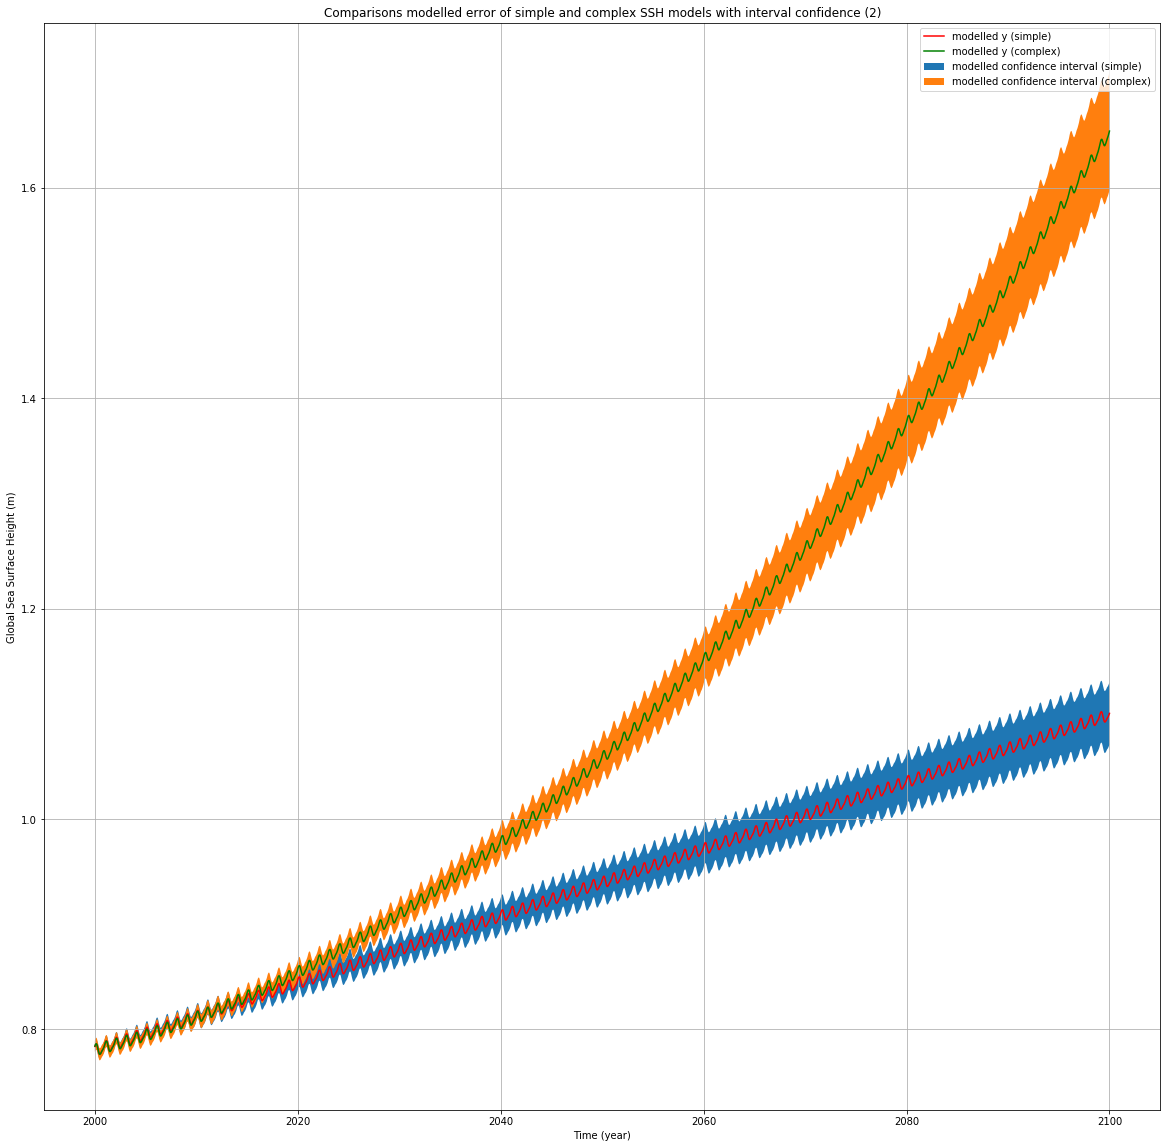

In [0]:
import matplotlib.pyplot as plt
plt.figure()

confidence_min_c=y_predict2-1.96*y_predict_var_c.flatten()
confidence_max_c=y_predict2+1.96*y_predict_var_c.flatten()

confidence_min_s=y_predict-1.96*y_predict_var_s.flatten()
confidence_max_s=y_predict+1.96*y_predict_var_s.flatten()

plt.fill_between(t_f/365,confidence_min_s,confidence_max_s, label='modelled confidence interval (simple)')
plt.plot(t_f/365,y_predict,'r',label='modelled y (simple)')


plt.fill_between(t_f/365,confidence_min_c,confidence_max_c, label='modelled confidence interval (complex)')
plt.plot(t_f/365,y_predict2,'g',label='modelled y (complex)')
plt.title('Comparisons modelled error of simple and complex SSH models with interval confidence (2)')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.legend()
plt.grid()

We observe that the error on the complex model grows faster here but doesn't add much more to the prediction.

# Local approach to estimate the sea level slope

In [0]:
%%bigquery --project alert-ground-261008 first
SELECT lon, lat,avg(ssh)
FROM bdo2020.bdo2020.1998_2015
WHERE time>=729390 and time<= 729390+365
group by lat,lon

In [0]:
%%bigquery --project alert-ground-261008 last
SELECT lon, lat,avg(ssh)
FROM bdo2020.bdo2020.1998_2015
WHERE time<=735963 and time>= 735963-365
group by lat,lon

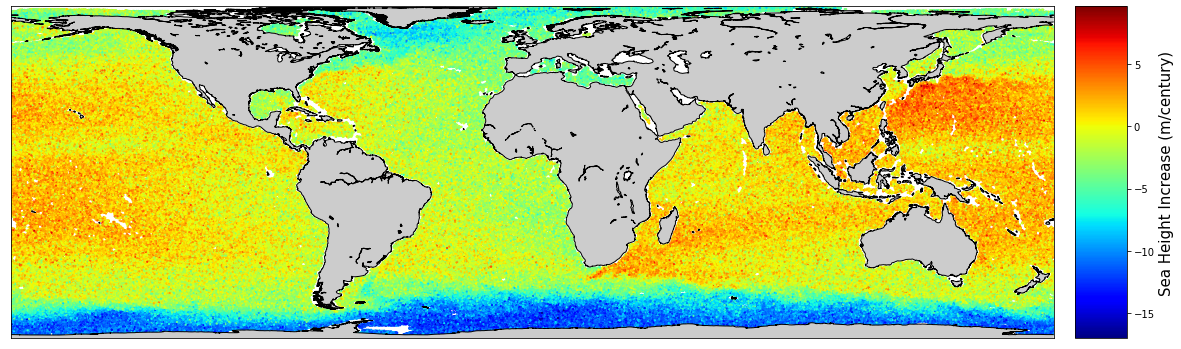

In [0]:
plot_im(last.lon,last.lat,(last.f0_-first.f0_)/18*100,5,'Sea Height Increase (m/century)')

#Study of Madagascar
Because seems to have an important increase 


In [0]:
%%bigquery --project alert-ground-261008 outputm
SELECT lon, lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-25 AND lat<-21 AND lon>44 AND lon<51
GROUP BY lon, lat

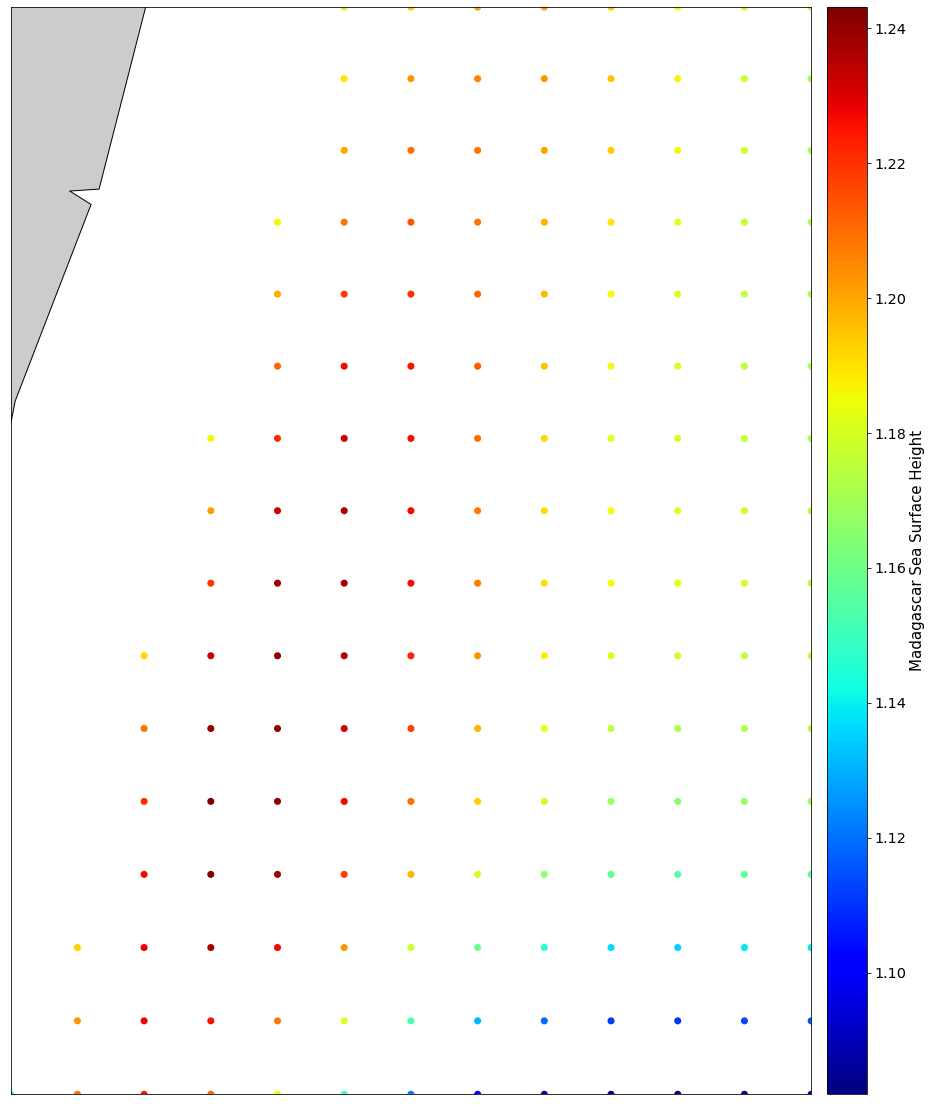

In [0]:
# Zone of study
plot_im(outputm.lon,outputm.lat,outputm.mean_ssh,50,'Madagascar Sea Surface Height')

In [0]:
%%bigquery --project alert-ground-261008 madagascar
SELECT time, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-25 AND lat<-21 AND lon>44 AND lon<51
GROUP BY time
ORDER BY time

In [0]:
madagascar


time  mean_ssh
0     729390.0  1.225753
1     729391.0  1.226811
2     729392.0  1.227645
3     729393.0  1.227002
4     729394.0  1.226961
...        ...       ...
6569  735959.0  1.347817
6570  735960.0  1.351769
6571  735961.0  1.354304
6572  735962.0  1.357753
6573  735963.0  1.360266

[6574 rows x 2 columns]

In [0]:
w=1/365.25
w2=6*w # 2 months cycle
w6=2*w # 6 months cycle


t=madagascar.time
# define a linear trend
x1=t
# define a annual seasonal cycle
x2 = np.sin(2*np.pi*t*w)
x3 = np.cos(2*np.pi*t*w)
# define a  2 months seasonal cycle
x4 = np.sin(2*np.pi*t*w2)
x5 = np.cos(2*np.pi*t*w2)
# define a  6 months seasonal cycle
x6 = np.sin(2*np.pi*t*w6)
x7 = np.cos(2*np.pi*t*w6)
### Seasonal cycles


# 1': create the matrix X
X2 = np.vstack((x1,x2,x3,x4,x5,x6,x7)).T

# 2': create the model, as before
model2 = LinearRegression()

# 3': fit the model, as before
model2.fit(X2,madagascar.mean_ssh)

# 4: get predicted values for y, as before
y_hat2 = model2.predict(X2)
print('rmse : ',mean_squared_error(madagascar.mean_ssh,y_hat2))

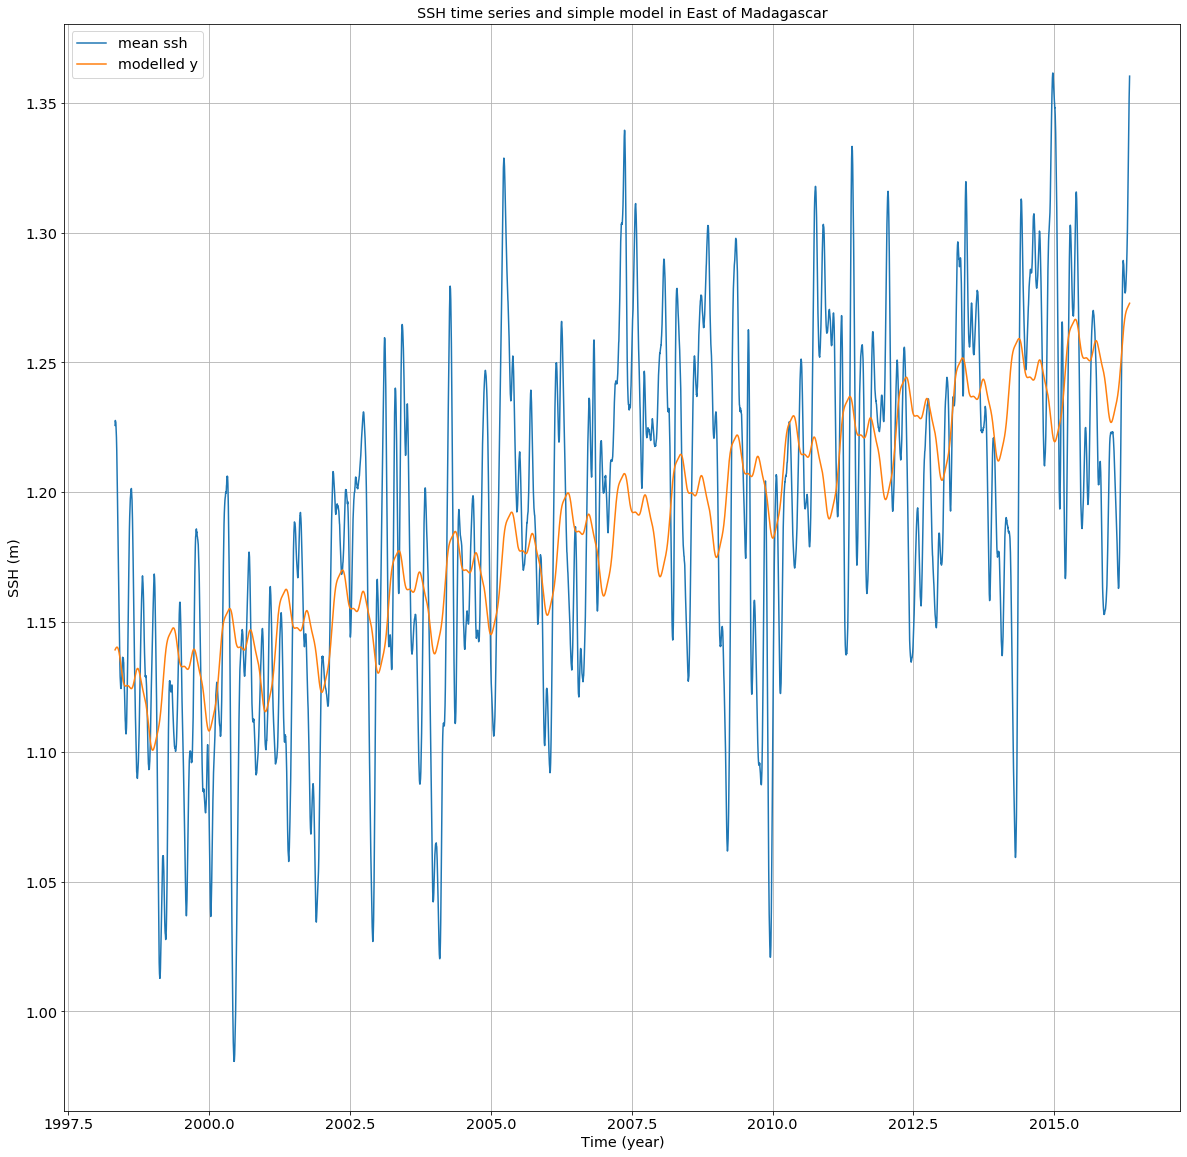

In [0]:
# 5: plot the real and modelled values
plt.figure()
plt.plot(t/365,madagascar.mean_ssh,label='mean ssh')
plt.plot(t/365,y_hat2,label='modelled y')
#plt.plot(t/365,model2.coef_[0]*t+model2.intercept_,label='trend')
plt.title('SSH time series and simple model in East of Madagascar')
plt.legend()
plt.xlabel('Time (year)')
plt.ylabel('SSH (m)')
plt.grid()

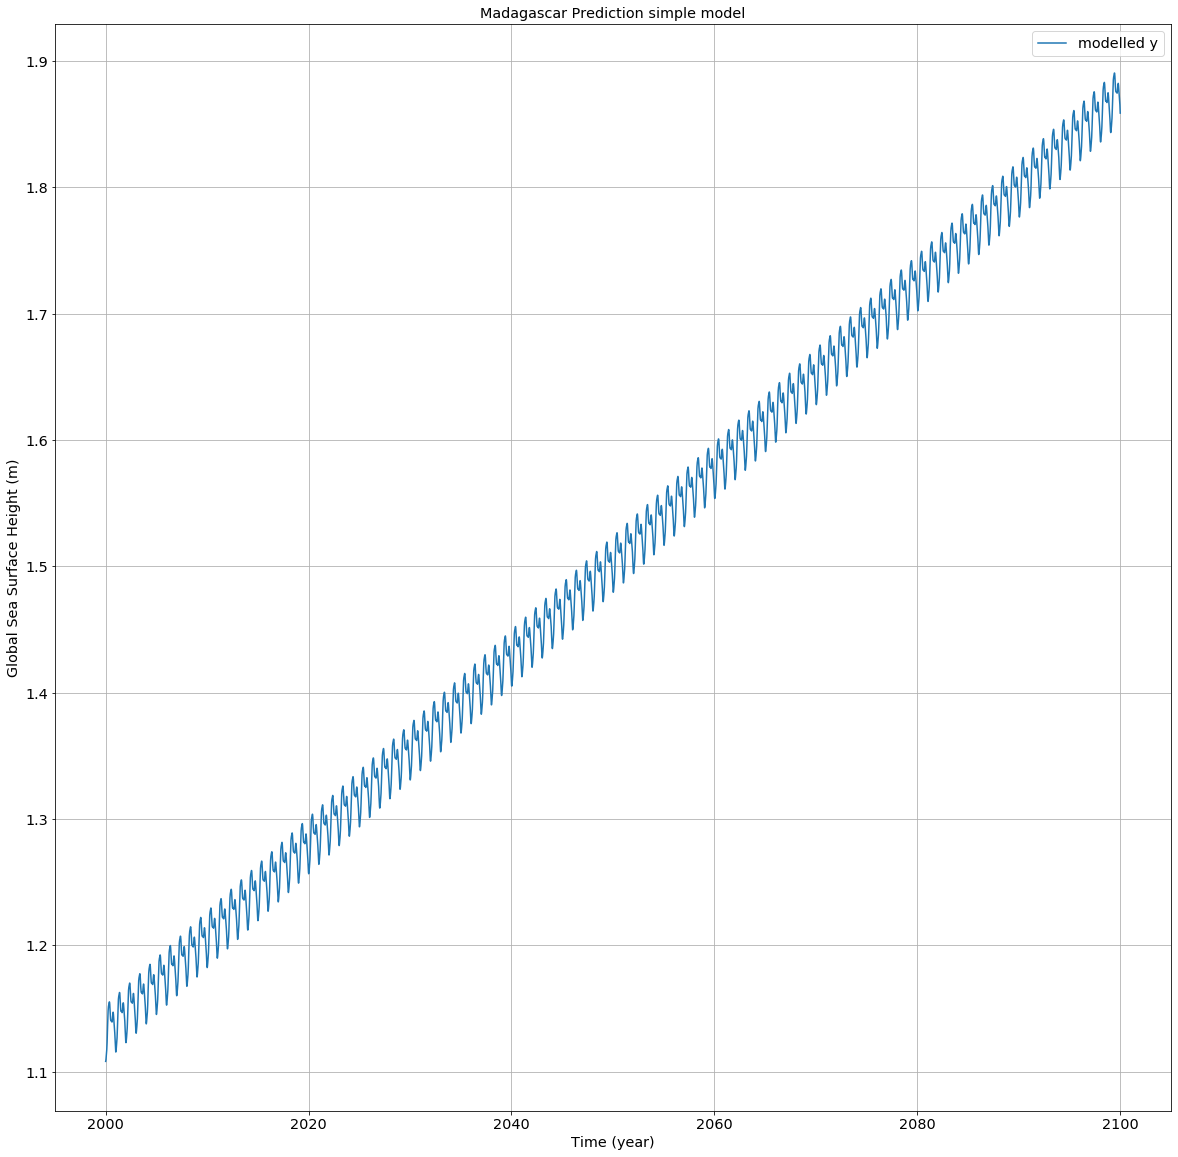

In [0]:
#prediction 2100 more complex model
end=730000+36500
t_f= np.linspace(730000,end, 36500)

x1f=t_f
# define a annual seasonal cycle
x2f = np.sin(2*np.pi*t_f*w)
x3f = np.cos(2*np.pi*t_f*w)
# define a 2 months seasonal cycle
x4f = np.sin(2*np.pi*t_f*w2)
x5f = np.cos(2*np.pi*t_f*w2)
# define a 6 months seasonal cycle
x6f = np.sin(2*np.pi*t_f*w6)
x7f = np.cos(2*np.pi*t_f*w6)
#x8f=t_f**2
#x9f=t_f**3

X2f = np.vstack((x1f,x2f,x3f,x4f,x5f,x6f,x7f)).T


y_predict2 = model2.predict(X2f)

# plot the prediction
plt.figure()
plt.plot(t_f/365,y_predict2,label='modelled y')
plt.title('Madagascar Prediction simple model')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.legend()
plt.grid()

#Study of Australia
Because seems to have a very important increase 


In [0]:
%%bigquery --project alert-ground-261008 output
SELECT lon, lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-33 AND lat<-25 AND lon>148 AND lon<156
GROUP BY lon, lat

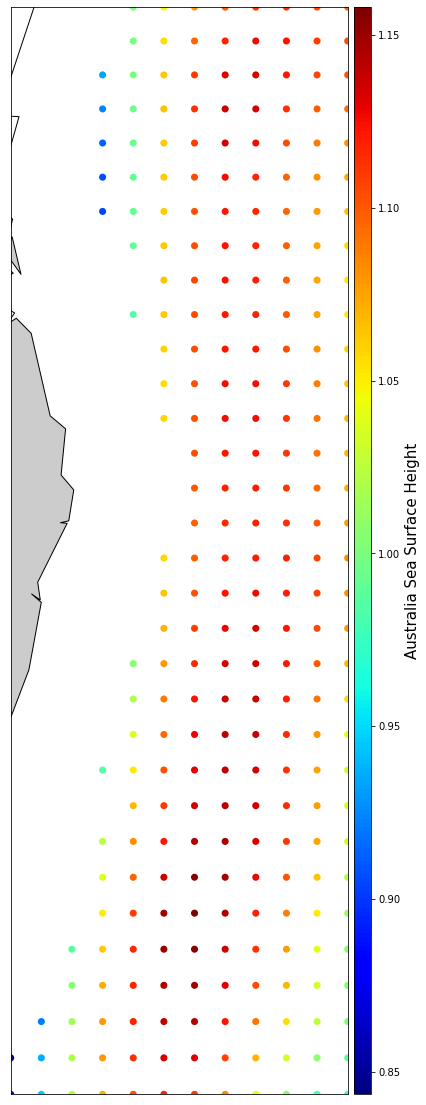

In [0]:
# Zone of study
plot_im(output.lon,output.lat,output.mean_ssh,50,'Australia Sea Surface Height')

In [0]:
%%bigquery --project alert-ground-261008 australia
SELECT time, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-33 AND lat<-25 AND lon>148 AND lon<156
GROUP BY time
ORDER BY time

In [0]:
australia


time  mean_ssh
0     729390.0  1.150346
1     729391.0  1.147806
2     729392.0  1.145200
3     729393.0  1.144864
4     729394.0  1.144597
...        ...       ...
6569  735959.0  1.225258
6570  735960.0  1.225560
6571  735961.0  1.226597
6572  735962.0  1.226958
6573  735963.0  1.226993

[6574 rows x 2 columns]

In [0]:
w=1/365.25
w2=6*w # 2 months cycle
w6=2*w # 6 months cycle


t=australia.time
# define a linear trend
x1=t
# define a annual seasonal cycle
x2 = np.sin(2*np.pi*t*w)
x3 = np.cos(2*np.pi*t*w)
# define a  2 months seasonal cycle
x4 = np.sin(2*np.pi*t*w2)
x5 = np.cos(2*np.pi*t*w2)
# define a  6 months seasonal cycle
x6 = np.sin(2*np.pi*t*w6)
x7 = np.cos(2*np.pi*t*w6)
### Seasonal cycles

x8=t**2
x9=t**3

# 1': create the matrix X
X2 = np.vstack((x1,x2,x3,x4,x5,x6,x7,x8,x9)).T

# 2': create the model, as before
model2 = LinearRegression()

# 3': fit the model, as before
model2.fit(X2,australia.mean_ssh)

# 4: get predicted values for y, as before
y_hat2 = model2.predict(X2)
print('rmse : ',mean_squared_error(australia.mean_ssh,y_hat2))

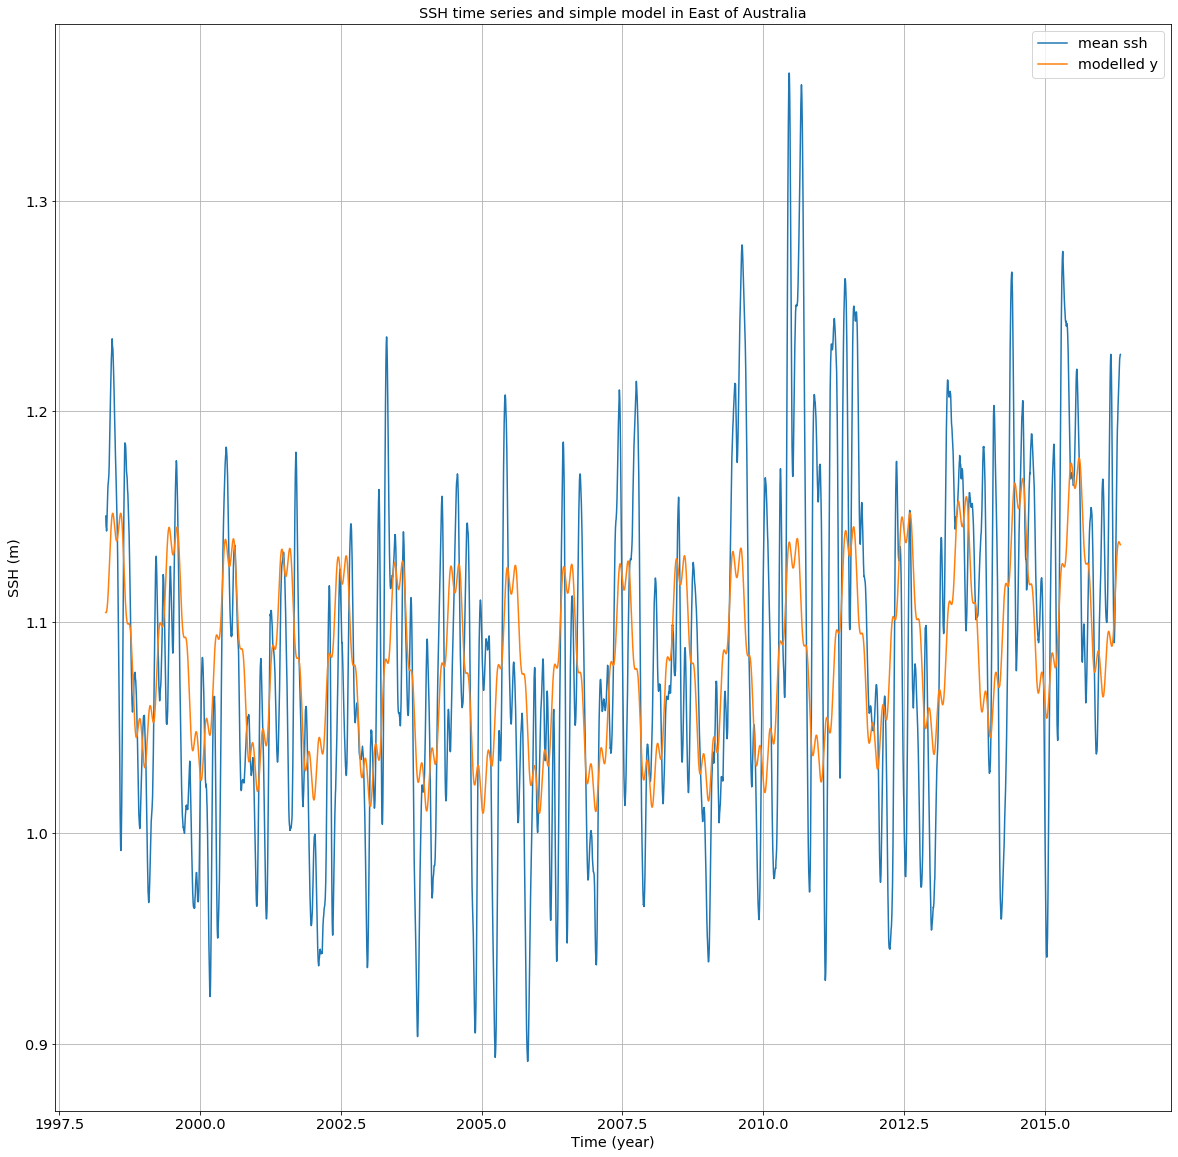

In [0]:
# 5: plot the real and modelled values
plt.figure()
plt.plot(t/365,australia.mean_ssh,label='mean ssh')
plt.plot(t/365,y_hat2,label='modelled y')
#plt.plot(t/365,model2.coef_[0]*t+model2.intercept_,label='trend')
plt.title('SSH time series and simple model in East of Australia')
plt.legend()
plt.xlabel('Time (year)')
plt.ylabel('SSH (m)')
plt.grid()

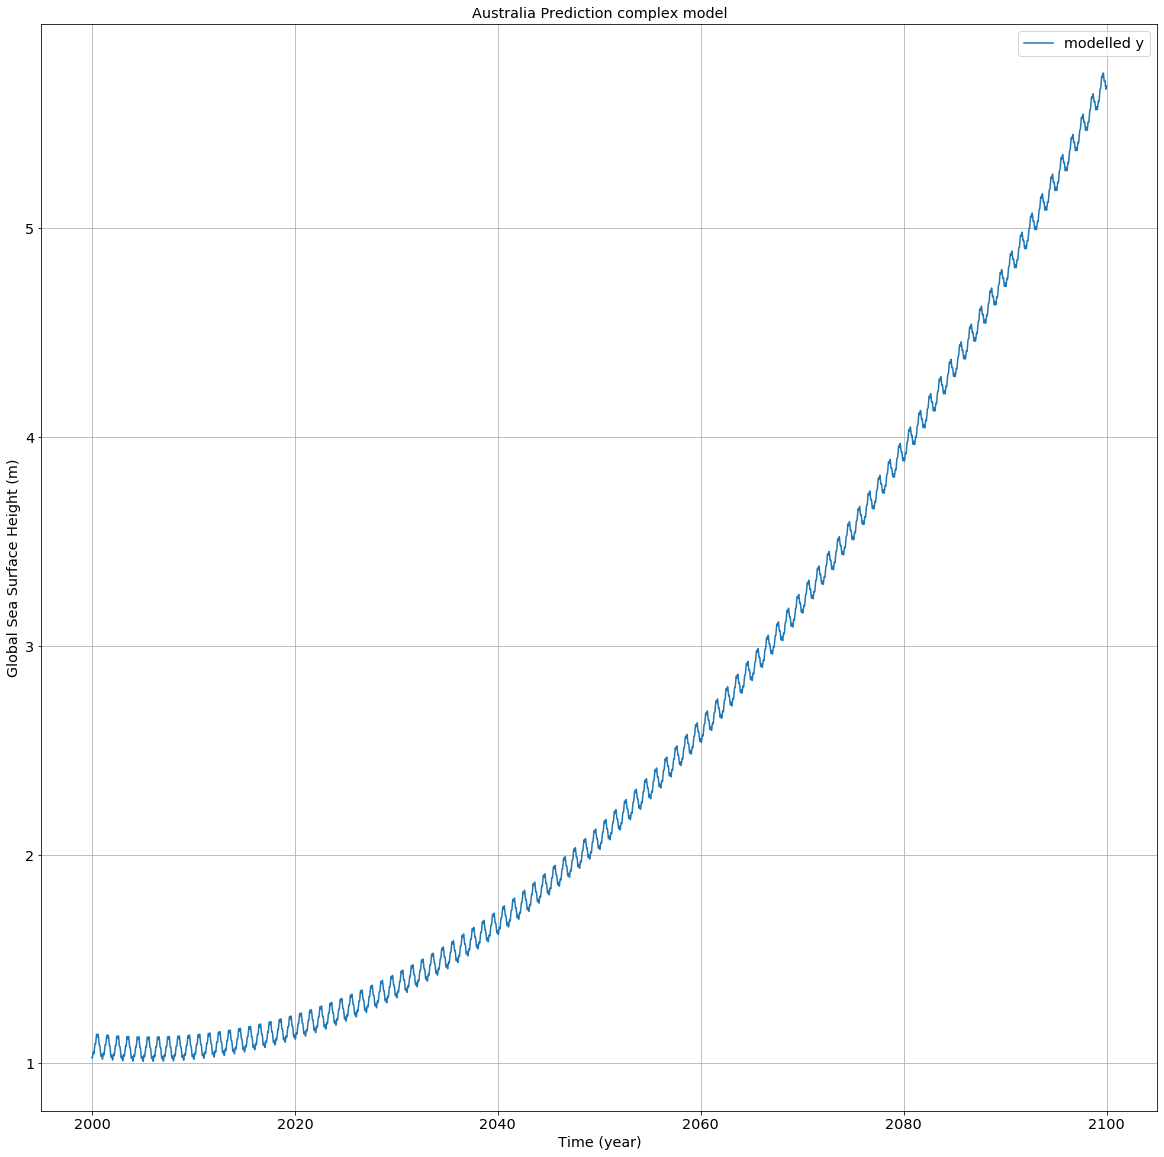

In [0]:
#prediction 2100 more complex model
end=730000+36500
t_f= np.linspace(730000,end, 36500)

x1f=t_f
# define a annual seasonal cycle
x2f = np.sin(2*np.pi*t_f*w)
x3f = np.cos(2*np.pi*t_f*w)
# define a 2 months seasonal cycle
x4f = np.sin(2*np.pi*t_f*w2)
x5f = np.cos(2*np.pi*t_f*w2)
# define a 6 months seasonal cycle
x6f = np.sin(2*np.pi*t_f*w6)
x7f = np.cos(2*np.pi*t_f*w6)
x8f=t_f**2
x9f=t_f**3

X2f = np.vstack((x1f,x2f,x3f,x4f,x5f,x6f,x7f,x8f,x9f)).T


y_predict4 = model2.predict(X2f)

# plot the predicted values
plt.figure()
plt.plot(t_f/365,y_predict4,label='modelled y')
plt.title('Australia Prediction complex model')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.legend()
plt.grid()

An incredible predicted increase of 6 m !!! ( wow (\*-\*) )

#Study of Red Sea
Because seems to have an important increase 


In [0]:
%%bigquery --project alert-ground-261008 red_sea
SELECT lon, lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>34 AND lon<41 AND lat>10 AND lat<20  #21.54238, 39.1979
GROUP BY lon, lat

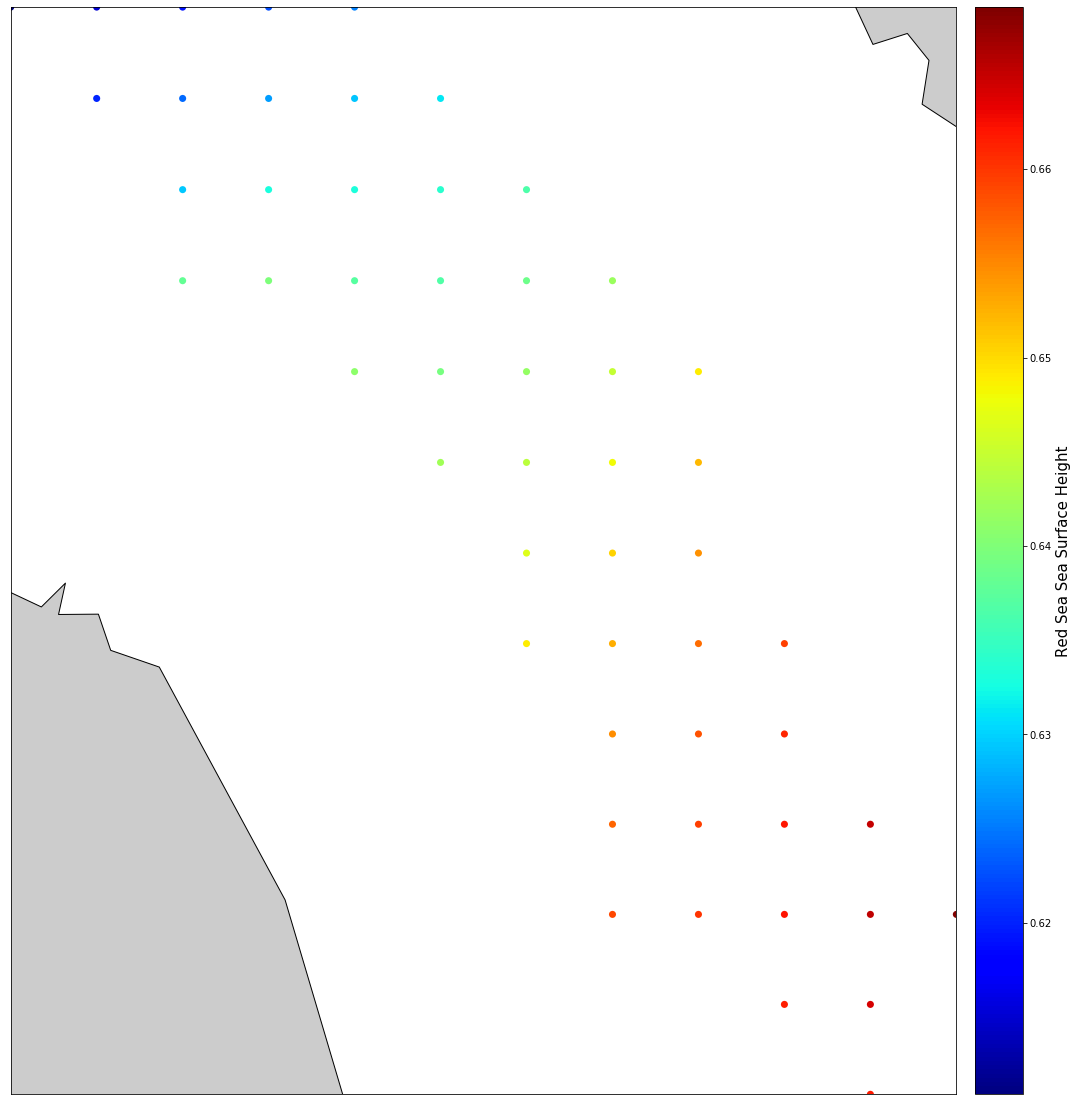

In [0]:
# Zone of study
plot_im(red_sea.lon,red_sea.lat,red_sea.mean_ssh,50,'Red Sea Sea Surface Height')

In [0]:
%%bigquery --project alert-ground-261008 redsea
SELECT time, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>34 AND lon<41 AND lat>10 AND lat<20 
GROUP BY time
ORDER BY time

In [0]:
redsea


time  mean_ssh
0     729390.0  0.780642
1     729391.0  0.764131
2     729392.0  0.747629
3     729393.0  0.732579
4     729394.0  0.722017
...        ...       ...
6569  735959.0  0.807073
6570  735960.0  0.815044
6571  735961.0  0.827627
6572  735962.0  0.841617
6573  735963.0  0.851010

[6574 rows x 2 columns]

In [0]:
w=1/365.25
w2=6*w # 2 months cycle
w6=2*w # 6 months cycle


t=redsea.time
# define a linear trend
x1=t
# define a annual seasonal cycle
x2 = np.sin(2*np.pi*t*w)
x3 = np.cos(2*np.pi*t*w)
# define a  2 months seasonal cycle
x4 = np.sin(2*np.pi*t*w2)
x5 = np.cos(2*np.pi*t*w2)
# define a  6 months seasonal cycle
x6 = np.sin(2*np.pi*t*w6)
x7 = np.cos(2*np.pi*t*w6)
### Seasonal cycles

x8=t**2
x9=t**3

# 1': create the matrix X
X2 = np.vstack((x1,x2,x3,x4,x5,x6,x7,x8,x9)).T

# 2': create the model, as before
model2 = LinearRegression()

# 3': fit the model, as before
model2.fit(X2,redsea.mean_ssh)

# 4: get predicted values for y, as before
y_hat2 = model2.predict(X2)
print('rmse : ',mean_squared_error(redsea.mean_ssh,y_hat2))

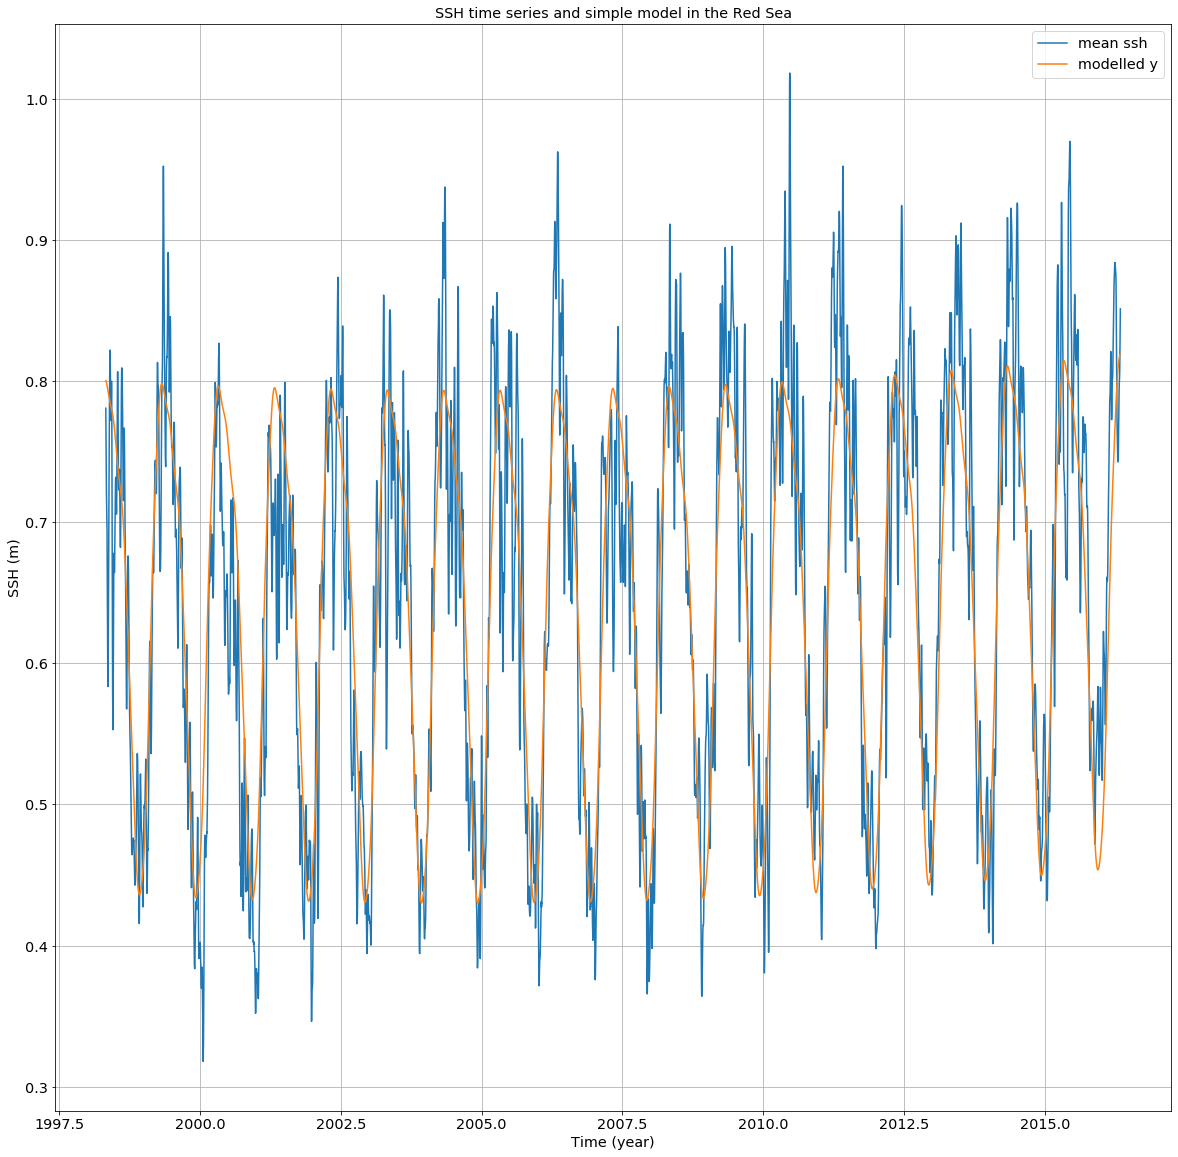

In [0]:
# 5: plot the real and modelled values
plt.figure()
plt.plot(t/365,redsea.mean_ssh,label='mean ssh')
plt.plot(t/365,y_hat2,label='modelled y')
plt.title('SSH time series and simple model in the Red Sea')
plt.legend()
plt.xlabel('Time (year)')
plt.ylabel('SSH (m)')
plt.grid()

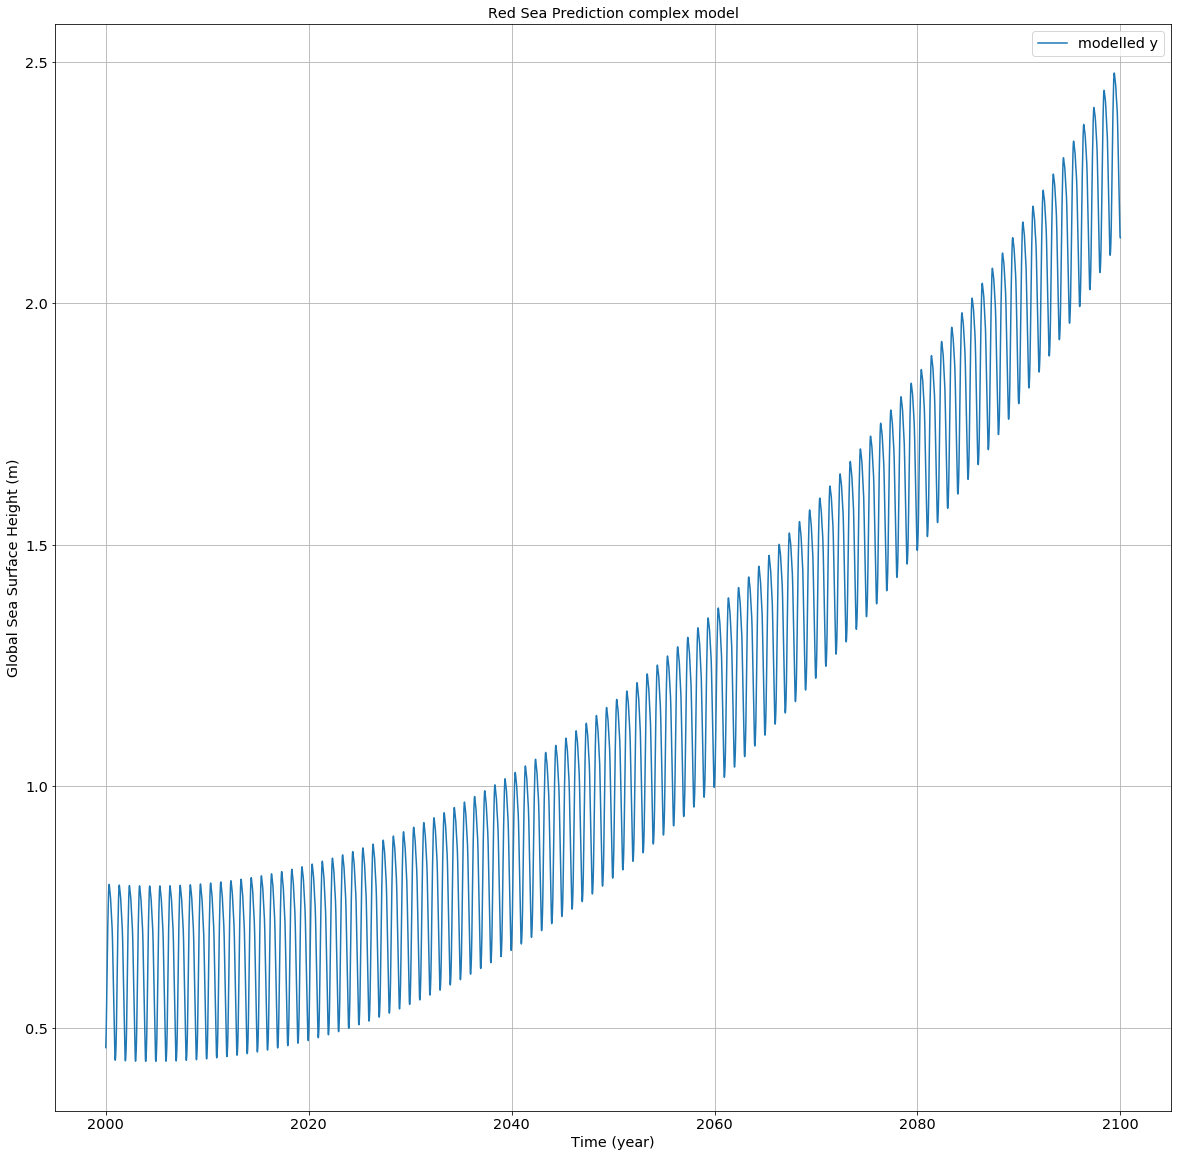

In [0]:
#prediction 2100 more complex model
end=730000+36500
t_f= np.linspace(730000,end, 36500)

x1f=t_f
# define a annual seasonal cycle
x2f = np.sin(2*np.pi*t_f*w)
x3f = np.cos(2*np.pi*t_f*w)
# define a 2 months seasonal cycle
x4f = np.sin(2*np.pi*t_f*w2)
x5f = np.cos(2*np.pi*t_f*w2)
# define a 6 months seasonal cycle
x6f = np.sin(2*np.pi*t_f*w6)
x7f = np.cos(2*np.pi*t_f*w6)
x8f=t_f**2
x9f=t_f**3

X2f = np.vstack((x1f,x2f,x3f,x4f,x5f,x6f,x7f,x8f,x9f)).T


y_predict3 = model2.predict(X2f)

# plot the predicted values
plt.figure()
plt.plot(t_f/365,y_predict3,label='modelled y')
plt.title('Red Sea Prediction complex model')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.legend()
plt.grid()

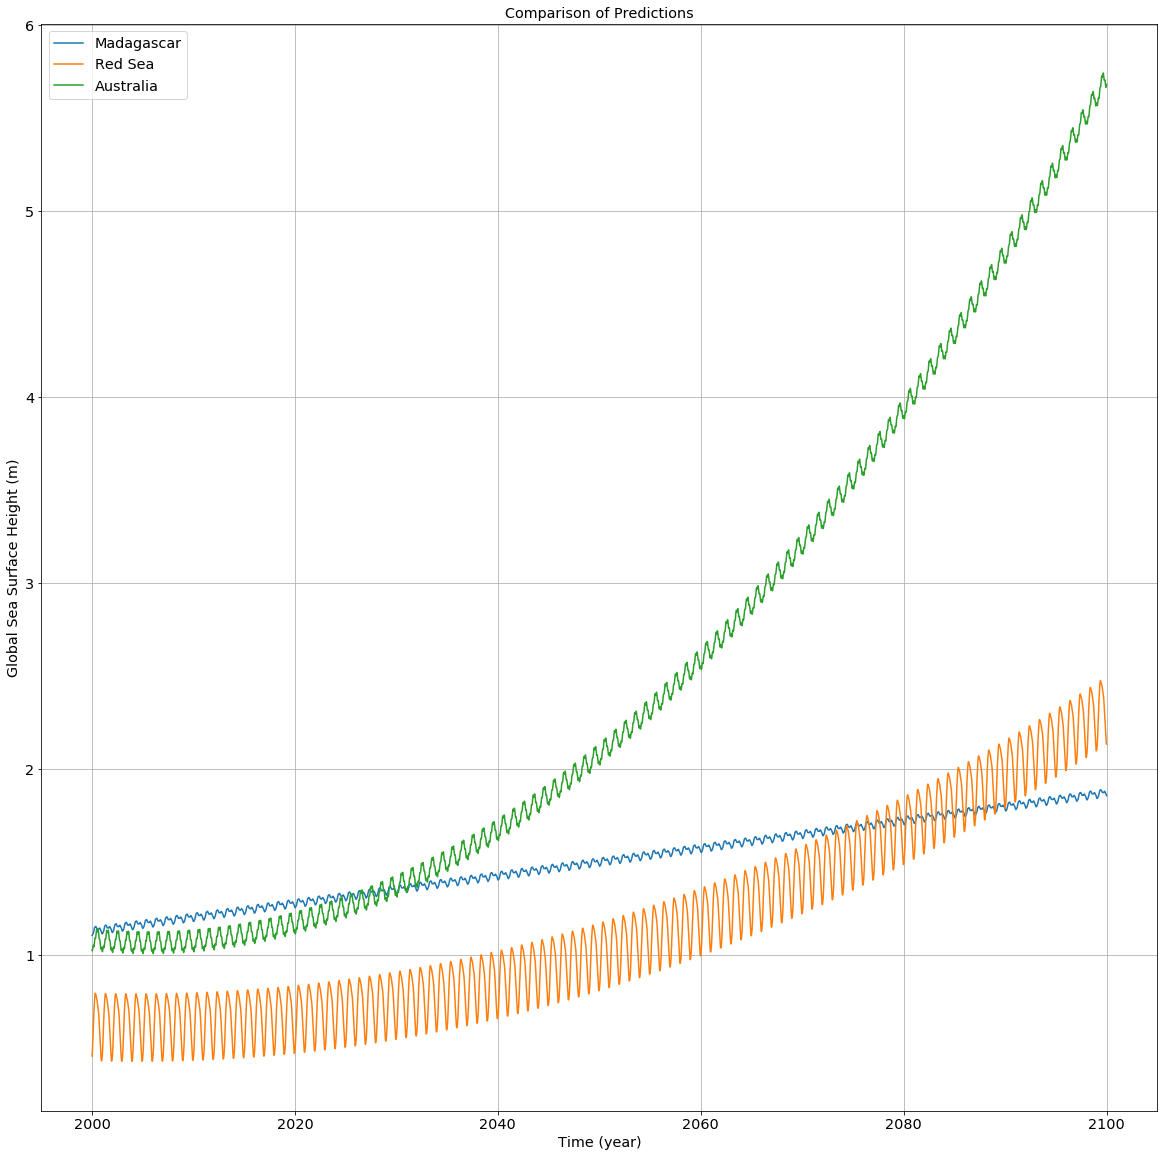

In [0]:
# 5: plot the real and modelled values
plt.figure()
plt.plot(t_f/365,y_predict2,label='Madagascar')
plt.plot(t_f/365,y_predict3,label='Red Sea')
plt.plot(t_f/365,y_predict4,label='Australia')

plt.title('Comparison of Predictions')
plt.xlabel('Time (year)')
plt.ylabel('Global Sea Surface Height (m)')
plt.legend()
plt.grid()


